# Article Relevance Prediction for NeotomaDB
## Model Iterations with Word Embeddings

This notebook contains the following tasks:
1. Import cleaned data from "../data/processed/metadata_processed.csv"
2. Add word embeddings
3. Train-Test split
4. Feature Selection
5. Hyperparameter tuning (with MLflow tracking)
6. Best Model

# 1. Import Data

In [1]:
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv, find_dotenv
import mlflow
import azureml
from mlflow.models.signature import infer_signature

load_dotenv(find_dotenv())

AZURE_MLFLOW_URI = os.environ.get("AZURE_MLFLOW_URI")
mlflow.set_tracking_uri(AZURE_MLFLOW_URI)

#### Create Training and Testing Data for Model Iteration 1 

In [2]:
import numpy as np
import pandas as pd
metadata_df = pd.read_csv("../../data/article-relevance/processed/metadata_processed.csv")
metadata_df.columns

Index(['Unnamed: 0', 'DOI', 'URL', 'abstract', 'author', 'container-title',
       'is-referenced-by-count', 'language', 'published', 'publisher',
       'subject', 'subtitle', 'title', 'target', 'published_year',
       'title_clean', 'subtitle_clean', 'abstract_clean', 'subject_clean',
       'has_abstract', 'text_with_abstract', 'text_wo_abstract', 'detectlang'],
      dtype='object')

In [3]:
training_keepcol = [
       'is-referenced-by-count', 
       'has_abstract', 
       'subject_clean',
       'text_with_abstract', 
       'target']

metadata_df_cleaned = metadata_df.loc[:, training_keepcol]

metadata_df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4434 entries, 0 to 4433
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is-referenced-by-count  4434 non-null   int64 
 1   has_abstract            4434 non-null   int64 
 2   subject_clean           4346 non-null   object
 3   text_with_abstract      4434 non-null   object
 4   target                  4434 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 173.3+ KB


In [4]:
#empty strings being imported as NaN's, so filling with empty strings
metadata_df_cleaned['subject_clean'] = metadata_df_cleaned['subject_clean'].fillna(value='')

# 2. Add Sentance Embeddings

> !pip install sentence_transformers

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('allenai/specter2')

No sentence-transformers model found with name /Users/kw/.cache/torch/sentence_transformers/allenai_specter2. Creating a new one with MEAN pooling.


In [6]:
# Create sentance embeddings
embeddings = metadata_df_cleaned['text_with_abstract'].apply(model.encode)

In [9]:
embeddings_formatted = pd.DataFrame(embeddings.tolist())
embeddings_formatted

0         1         2         3         4         5         6    \
0    -0.367841 -0.682618  0.481659 -0.076614  1.361158 -0.055952  0.724120   
1     0.436005  0.040026 -0.203677 -0.304372  0.277975  0.072686  0.762866   
2     0.744607 -0.652021 -0.380955  0.007732  0.814745  0.259691  0.131211   
3     0.114701 -0.218918 -0.305862  0.614540  0.312255 -0.054838  0.108858   
4    -0.056214 -0.403606 -0.136764  0.089092  1.015412  0.202195  0.999896   
...        ...       ...       ...       ...       ...       ...       ...   
4430  0.339417  0.101199 -0.458718  0.058226  0.759643 -0.291644  0.643178   
4431  0.269436 -0.041214  0.302663  0.339386  0.111603 -0.455084 -0.111151   
4432  0.319937 -0.013901  0.332743  0.412342  0.308393 -0.295955  0.754990   
4433 -0.070910 -0.745114 -0.032809  0.515964  0.676877 -0.072093  0.420317   
4434  0.760275  0.349576  0.023005  0.566948  0.249675 -0.575887  0.641250   

           7         8         9    ...       758       759       760  \
0     0.029236 -0.371343  0.208466  ... -0.043954  0.052891  0.146780   
1     0.811004 -0.300561  0.721993  ... -0.302171 -0.684025  0.423019   
2    -0.164518  0.045866  0.564709  ... -0.041242  0.003290  0.151888   
3     0.566724 -0.105552  0.201352  ...  0.097129 -0.540970 -0.165240   
4     0.329975 -0.535107  0.656730  ... -0.054828 -0.227087  0.086429   
...        ...       ...       ...  ...       ...       ...       ...   
4430  0.593418 -0.088356 -0.144444  ... -0.083288 -0.187606  0.160323   
4431  1.140449 -0.013668 -0.019977  ...  0.135322  0.304750  0.686558   
4432  0.423491 -0.381034  0.210434  ... -0.444082 -0.698346  0.242722   
4433  0.511388 -0.044020  0.234968  ... -0.007636  0.587618  0.460993   
4434  0.573805 -0.176397 -0.055687  ... -0.319490 -0.600497  0.286195   

           761       762       763       764       765       766       767  
0    -1.735587 -0.043915 -0.297620  0.090835  0.194451 -0.420138 -0.231142  
1    -1.777156  0.134475 -0.994175  0.069995  0.323936  0.398270 -0.962721  
2    -1.156450 -0.571584 -0.730974 -0.192784 -0.371344  0.129544 -0.870950  
3    -0.534668 -0.509150 -0.612954 -0.172338 -0.157656 -0.290807 -0.581540  
4    -0.868923 -0.564220 -1.107351 -0.470971  0.183784  0.100971 -0.944220  
...        ...       ...       ...       ...       ...       ...       ...  
4430 -0.668525 -0.386127 -0.943945 -0.193551  0.228726 -0.383796 -0.855458  
4431 -0.649246 -0.523400 -0.502265 -0.724967  0.285527 -0.024432 -0.772663  
4432 -1.255496 -0.090500 -0.399208 -0.166269 -0.041473 -0.598962 -0.606830  
4433 -0.659403 -0.442102 -0.274008  0.179789 -0.276637 -0.229170 -0.824705  
4434 -0.703317 -0.644413 -0.365377 -0.172037 -0.481472 -0.266932 -1.006385  

[4435 rows x 768 columns]

In [10]:
#save embeddings
embeddings_formatted.to_csv("../../data/article-relevance/raw/embeddings.csv")

In [5]:
# Read From Dataframe
embeddings_df = pd.read_csv("../../data/article-relevance/raw/embeddings.csv", index_col=0)
embeddings_df.columns = embeddings_df.columns.astype(str) # require column names as strings for modelling
embeddings_df

0         1         2         3         4         5         6  \
0    -0.367841 -0.682618  0.481659 -0.076614  1.361158 -0.055952  0.724120   
1     0.436005  0.040026 -0.203677 -0.304372  0.277975  0.072686  0.762866   
2     0.744607 -0.652021 -0.380955  0.007732  0.814745  0.259691  0.131211   
3     0.114701 -0.218918 -0.305862  0.614540  0.312255 -0.054838  0.108858   
4    -0.056214 -0.403606 -0.136764  0.089092  1.015412  0.202195  0.999896   
...        ...       ...       ...       ...       ...       ...       ...   
4429  0.339417  0.101199 -0.458718  0.058226  0.759644 -0.291644  0.643178   
4430  0.269436 -0.041214  0.302663  0.339386  0.111603 -0.455084 -0.111151   
4431  0.319937 -0.013901  0.332743  0.412342  0.308393 -0.295955  0.754990   
4432 -0.070910 -0.745114 -0.032809  0.515964  0.676877 -0.072093  0.420317   
4433  0.760275  0.349576  0.023005  0.566948  0.249675 -0.575887  0.641250   

             7         8         9  ...       758       759       760  \
0     0.029236 -0.371343  0.208466  ... -0.043954  0.052891  0.146780   
1     0.811004 -0.300561  0.721993  ... -0.302171 -0.684025  0.423019   
2    -0.164518  0.045866  0.564709  ... -0.041242  0.003290  0.151888   
3     0.566724 -0.105552  0.201352  ...  0.097129 -0.540970 -0.165240   
4     0.329975 -0.535107  0.656730  ... -0.054828 -0.227087  0.086429   
...        ...       ...       ...  ...       ...       ...       ...   
4429  0.593418 -0.088356 -0.144444  ... -0.083288 -0.187606  0.160323   
4430  1.140449 -0.013668 -0.019977  ...  0.135322  0.304750  0.686558   
4431  0.423491 -0.381034  0.210434  ... -0.444082 -0.698346  0.242723   
4432  0.511388 -0.044020  0.234968  ... -0.007636  0.587618  0.460993   
4433  0.573805 -0.176397 -0.055687  ... -0.319490 -0.600497  0.286195   

           761       762       763       764       765       766       767  
0    -1.735587 -0.043915 -0.297620  0.090835  0.194451 -0.420138 -0.231142  
1    -1.777157  0.134475 -0.994175  0.069995  0.323936  0.398270 -0.962721  
2    -1.156450 -0.571584 -0.730974 -0.192784 -0.371344  0.129544 -0.870950  
3    -0.534668 -0.509150 -0.612954 -0.172338 -0.157656 -0.290807 -0.581540  
4    -0.868923 -0.564220 -1.107351 -0.470971  0.183784  0.100971 -0.944220  
...        ...       ...       ...       ...       ...       ...       ...  
4429 -0.668525 -0.386127 -0.943945 -0.193551  0.228726 -0.383796 -0.855458  
4430 -0.649246 -0.523401 -0.502265 -0.724967  0.285527 -0.024432 -0.772663  
4431 -1.255496 -0.090500 -0.399208 -0.166269 -0.041473 -0.598962 -0.606830  
4432 -0.659403 -0.442102 -0.274008  0.179789 -0.276637 -0.229170 -0.824705  
4433 -0.703317 -0.644413 -0.365377 -0.172037 -0.481472 -0.266932 -1.006385  

[4434 rows x 768 columns]

In [6]:
# Joining embeddings to DataFrame
metadata_df_cleaned = pd.concat([metadata_df_cleaned, embeddings_df], axis = 1)
metadata_df_cleaned.columns

Index(['is-referenced-by-count', 'has_abstract', 'subject_clean',
       'text_with_abstract', 'target', '0', '1', '2', '3', '4',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=773)

# 3. Train-Test Split

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

In [8]:
train_df, val_test_df = train_test_split(metadata_df_cleaned, test_size=0.3, random_state=123)
valid_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=123)

train_df.head()

is-referenced-by-count  has_abstract  \
4221                       6             0   
3288                       0             0   
3869                       3             0   
3398                       0             0   
4196                       0             0   

                                          subject_clean  \
4221                                  Multidisciplinary   
3288  Infectious Diseases Public Health, Environment...   
3869             Pollution Aquatic Science Oceanography   
3398                                      Plant Science   
4196                                      Plant Science   

                                     text_with_abstract  target         0  \
4221  Maritime Paleoindian technology, subsistence, ...       0  0.579186   
3288  Mycetoma – a history of the first contribution...       0  0.477060   
3869  Diatom assemblages from sediment traps in resp...       0  0.128601   
3398  Fossil pollen resolves origin of the South Afr...       1  0.799006   
4196  The history of olive cultivation in the southe...       1  0.546940   

             1         2         3         4  ...       758       759  \
4221 -0.092632 -0.111798  0.193873  0.229161  ... -0.260911 -0.537787   
3288 -0.336245  0.225431  0.324308  0.580096  ... -0.302911  0.304369   
3869  0.088006  0.606217  0.963918  0.210807  ...  0.148401 -0.448286   
3398  0.072416  0.167970 -0.102468  0.250834  ... -0.448956 -0.085374   
4196  0.450331 -0.012919  0.462011  0.295008  ... -0.217269  0.090376   

           760       761       762       763       764       765       766  \
4221  0.293415 -0.576466 -0.481050 -0.332881 -0.605197 -0.119935 -0.106829   
3288  0.143716 -0.324644 -0.624726 -0.491619 -0.119483 -0.083295  0.154700   
3869  0.345021 -1.598382 -0.367895 -0.399962 -0.487801 -0.284578 -0.610243   
3398  0.315138 -0.389148  0.214994 -0.946495 -0.506957  0.467604  0.129413   
4196  0.170954 -0.344694 -0.606358 -0.744387 -0.732909  0.199213 -0.142942   

           767  
4221 -0.556662  
3288 -0.293703  
3869 -0.559385  
3398 -0.569880  
4196 -0.524134  

[5 rows x 773 columns]

In [9]:
print(train_df.shape, valid_df.shape, test_df.shape)

(3103, 773) (665, 773) (666, 773)


### EDA for Train Split

In [10]:
train_df.sort_index()
train_df.info() # check non-null 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3103 entries, 4221 to 3582
Columns: 773 entries, is-referenced-by-count to 767
dtypes: float64(768), int64(3), object(2)
memory usage: 18.3+ MB


In [11]:
pos_df = train_df[train_df["target"] == 1]
neg_df = train_df[train_df["target"] == 0]

In [12]:
print("With Abstract")
sorted_pos_df = pos_df.reindex(pos_df.text_with_abstract.str.len().sort_values().index)
sorted_neg_df = neg_df.reindex(neg_df.text_with_abstract.str.len().sort_values().index)
avg_pos_len = pos_df.text_with_abstract.str.len().mean()
avg_neg_len = neg_df.text_with_abstract.str.len().mean()
print(avg_pos_len)
print(avg_neg_len)

With Abstract
748.9921507064364
858.006893755069


In [13]:
# sorted_pos_df.head()

In [14]:
# sorted_neg_df.head()

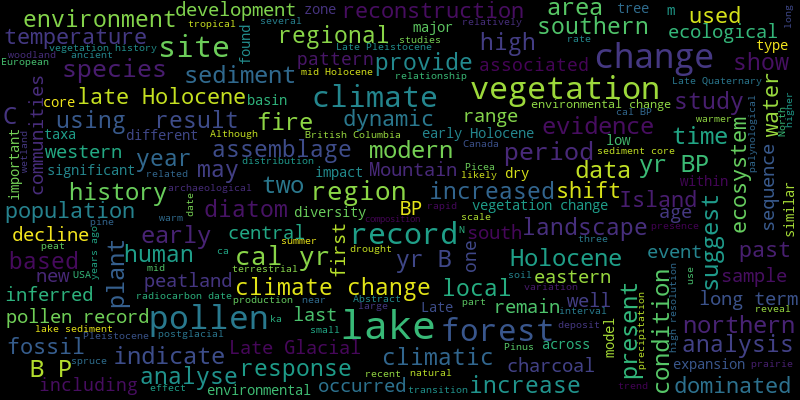

In [15]:
from wordcloud import WordCloud

pos_text = " ".join(train_df[train_df["target"] == 1]["text_with_abstract"].tolist())
neg_text = " ".join(train_df[train_df["target"] == 0]["text_with_abstract"].tolist())

wordcloud = WordCloud(max_font_size=40, width=800, height=400)
wordcloud.generate(pos_text).to_image()

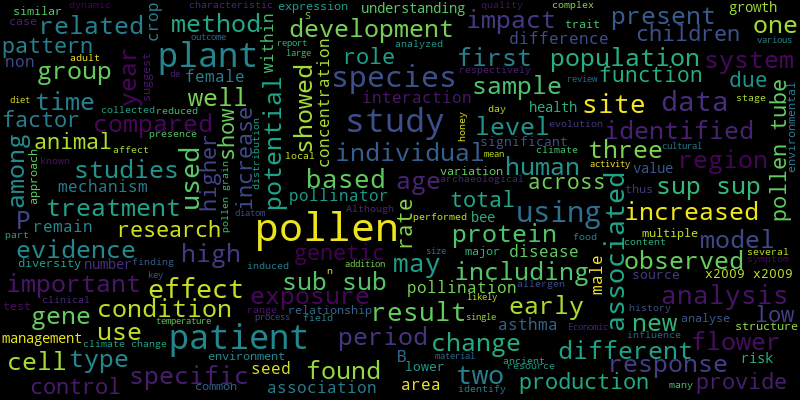

In [16]:
wordcloud.generate(neg_text).to_image()

#### Examine class distribution in train split

In [17]:
train_df["target"].value_counts(normalize=True)

0    0.794715
1    0.205285
Name: target, dtype: float64

# 4. Modelling with Sentence Embeddings

### 4.1 Preprocessor

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline

In [19]:
train_df.columns

Index(['is-referenced-by-count', 'has_abstract', 'subject_clean',
       'text_with_abstract', 'target', '0', '1', '2', '3', '4',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=773)

In [20]:
X_train, y_train = train_df.drop(columns = ["target", "text_with_abstract"]), train_df["target"]
X_valid, y_valid = valid_df.drop(columns = ["target", "text_with_abstract"]), valid_df["target"]
X_test, y_test = test_df.drop(columns = ["target", "text_with_abstract"]), test_df["target"]

In [21]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer

# Dividing the feature types
text_features = "subject_clean"
text_transformer = CountVectorizer(stop_words="english", max_features= 1000)

binary_feature = ['has_abstract']
binary_transformer = OneHotEncoder(drop='if_binary', dtype = int)

numeric_features = ["is-referenced-by-count"]
numeric_transformer = StandardScaler()

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers = [
    ("num_preprocessor", numeric_transformer, numeric_features),
    ("binary_preprocessor", binary_transformer, binary_feature),
    ("text_preprocessor", text_transformer, text_features)
    ],
    remainder = "passthrough"
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_preprocessor', StandardScaler(),
                                 ['is-referenced-by-count']),
                                ('binary_preprocessor',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['has_abstract']),
                                ('text_preprocessor',
                                 CountVectorizer(max_features=1000,
                                                 stop_words='english'),
                                 'subject_clean')])

##### Check Transformed Data

In [22]:
transformed_X_train = preprocessor.fit_transform(X_train)
transformed_X_train

array([[-0.22459416,  0.        ,  0.        , ..., -0.11993516,
        -0.10682936, -0.55666184],
       [-0.37773439,  0.        ,  0.        , ..., -0.08329452,
         0.15470023, -0.29370296],
       [-0.30116427,  0.        ,  0.        , ..., -0.28457794,
        -0.6102425 , -0.5593848 ],
       ...,
       [-0.37773439,  1.        ,  0.        , ...,  0.17430277,
        -0.03955231, -0.4979284 ],
       [-0.37773439,  0.        ,  0.        , ..., -0.6606051 ,
         0.20481375, -1.1235573 ],
       [-0.37773439,  0.        ,  0.        , ...,  0.00753142,
        -0.45005253, -0.85647833]])

In [23]:
col_names = (preprocessor.named_transformers_["num_preprocessor"].get_feature_names_out().tolist() +
             preprocessor.named_transformers_["binary_preprocessor"].get_feature_names_out().tolist() + 
             preprocessor.named_transformers_["text_preprocessor"].get_feature_names_out().tolist() + 
             embeddings_df.columns.tolist())
len(col_names)

1088

In [24]:
transformed_X_train_df = pd.DataFrame(transformed_X_train, columns=col_names)
transformed_X_train_df.head(3)

is-referenced-by-count  has_abstract_1  accounting  administration  \
0               -0.224594             0.0         0.0             0.0   
1               -0.377734             0.0         0.0             0.0   
2               -0.301164             0.0         0.0             0.0   

   advanced  aerospace  aging  agricultural  agronomy  aided  ...       758  \
0       0.0        0.0    0.0           0.0       0.0    0.0  ... -0.260911   
1       0.0        0.0    0.0           0.0       0.0    0.0  ... -0.302911   
2       0.0        0.0    0.0           0.0       0.0    0.0  ...  0.148401   

        759       760       761       762       763       764       765  \
0 -0.537787  0.293415 -0.576466 -0.481050 -0.332881 -0.605197 -0.119935   
1  0.304369  0.143716 -0.324644 -0.624726 -0.491619 -0.119483 -0.083295   
2 -0.448286  0.345021 -1.598382 -0.367895 -0.399962 -0.487801 -0.284578   

        766       767  
0 -0.106829 -0.556662  
1  0.154700 -0.293703  
2 -0.610243 -0.559385  

[3 rows x 1088 columns]

### 4.2 Model Comparison

In [25]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [26]:
# Helper function for comparing models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns pandas Series with mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [27]:
classification_metrics = ["f1", "precision", "recall", "accuracy"]

In [28]:
results_dict = {}
# models = {
# 	"dummy": DummyClassifier(random_state = 123),
#   "logistic regression": LogisticRegression(max_iter=1000, random_state=123),
#     "decision tree": DecisionTreeClassifier(random_state=123, max_depth=200),
#     "kNN": KNeighborsClassifier(),
#     'NaiveBayes': BernoulliNB(alpha=1),
#     "RBF SVM": SVC(random_state=123),
#     'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
#     'LGBM': LGBMClassifier(random_state=123),
#     'Cat Boost': CatBoostClassifier(verbose=0, random_state=123),
#     'XGB' : XGBClassifier(random_state=123, verbosity=0),
#     'sklearn_histGB': HistGradientBoostingClassifier(random_state=123),
#     "sklearn_GB": GradientBoostingClassifier(random_state=123)
#     }

models = {
	"dummy": DummyClassifier(random_state = 123),
    'Logistic Regression': LogisticRegression(class_weight="balanced", max_iter=1000, random_state=123),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=123, max_depth=200),
    "kNN": KNeighborsClassifier(),
    'Naive Bayes': BernoulliNB(),
    "RBF SVM": SVC(class_weight="balanced", random_state=123),
    'RF': RandomForestClassifier(class_weight="balanced", random_state=123),
    'LGBM': LGBMClassifier(class_weight="balanced", random_state=123),
    # 'CatBoost': CatBoostClassifier(verbose=0, random_state=123),
    'XGBoost': XGBClassifier(class_weight="balanced", random_state=123, verbosity=0),
    'sklearn_histGB': HistGradientBoostingClassifier(random_state=123),
    'sklearn_GB': GradientBoostingClassifier(random_state=123)
    }

for key, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results_dict[key] = mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True, scoring=classification_metrics)

results_df = pd.DataFrame(results_dict).T
results_df


/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

fit_time         score_time            test_f1  \
dummy                 0.048 (+/- 0.017)  0.018 (+/- 0.005)  0.000 (+/- 0.000)   
Logistic Regression   0.626 (+/- 0.079)  0.020 (+/- 0.001)  0.894 (+/- 0.024)   
Decision Tree         1.539 (+/- 0.145)  0.015 (+/- 0.002)  0.763 (+/- 0.027)   
kNN                   0.047 (+/- 0.006)  0.079 (+/- 0.027)  0.904 (+/- 0.014)   
Naive Bayes           0.077 (+/- 0.006)  0.026 (+/- 0.002)  0.813 (+/- 0.010)   
RBF SVM               0.700 (+/- 0.017)  0.167 (+/- 0.006)  0.896 (+/- 0.023)   
RF                    2.697 (+/- 0.095)  0.027 (+/- 0.001)  0.878 (+/- 0.013)   
LGBM                  2.443 (+/- 0.408)  0.025 (+/- 0.002)  0.915 (+/- 0.016)   
XGBoost               4.094 (+/- 0.272)  0.030 (+/- 0.003)  0.917 (+/- 0.016)   
sklearn_histGB        5.768 (+/- 0.518)  0.028 (+/- 0.008)  0.921 (+/- 0.019)   
sklearn_GB           45.787 (+/- 0.851)  0.015 (+/- 0.001)  0.905 (+/- 0.018)   

                              train_f1     test_precision    train_precision  \
dummy                0.000 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
Logistic Regression  0.987 (+/- 0.002)  0.878 (+/- 0.036)  0.974 (+/- 0.005)   
Decision Tree        1.000 (+/- 0.000)  0.776 (+/- 0.020)  1.000 (+/- 0.000)   
kNN                  0.938 (+/- 0.002)  0.942 (+/- 0.018)  0.968 (+/- 0.005)   
Naive Bayes          0.814 (+/- 0.004)  0.701 (+/- 0.015)  0.702 (+/- 0.006)   
RBF SVM              0.924 (+/- 0.006)  0.850 (+/- 0.024)  0.876 (+/- 0.009)   
RF                   1.000 (+/- 0.000)  0.963 (+/- 0.006)  1.000 (+/- 0.000)   
LGBM                 1.000 (+/- 0.000)  0.939 (+/- 0.015)  1.000 (+/- 0.000)   
XGBoost              1.000 (+/- 0.000)  0.945 (+/- 0.003)  1.000 (+/- 0.000)   
sklearn_histGB       1.000 (+/- 0.000)  0.953 (+/- 0.010)  1.000 (+/- 0.000)   
sklearn_GB           1.000 (+/- 0.000)  0.942 (+/- 0.006)  1.000 (+/- 0.000)   

                           test_recall       train_recall      test_accuracy  \
dummy                0.000 (+/- 0.000)  0.000 (+/- 0.000)  0.795 (+/- 0.001)   
Logistic Regression  0.912 (+/- 0.033)  1.000 (+/- 0.001)  0.956 (+/- 0.011)   
Decision Tree        0.750 (+/- 0.038)  1.000 (+/- 0.000)  0.904 (+/- 0.010)   
kNN                  0.870 (+/- 0.022)  0.911 (+/- 0.007)  0.962 (+/- 0.005)   
Naive Bayes          0.967 (+/- 0.010)  0.970 (+/- 0.002)  0.908 (+/- 0.006)   
RBF SVM              0.948 (+/- 0.030)  0.978 (+/- 0.004)  0.955 (+/- 0.010)   
RF                   0.807 (+/- 0.022)  1.000 (+/- 0.000)  0.954 (+/- 0.004)   
LGBM                 0.893 (+/- 0.033)  1.000 (+/- 0.000)  0.966 (+/- 0.006)   
XGBoost              0.892 (+/- 0.032)  1.000 (+/- 0.000)  0.967 (+/- 0.006)   
sklearn_histGB       0.892 (+/- 0.041)  1.000 (+/- 0.000)  0.969 (+/- 0.007)   
sklearn_GB           0.871 (+/- 0.034)  1.000 (+/- 0.000)  0.963 (+/- 0.006)   

                        train_accuracy  
dummy                0.795 (+/- 0.000)  
Logistic Regression  0.995 (+/- 0.001)  
Decision Tree        1.000 (+/- 0.000)  
kNN                  0.975 (+/- 0.001)  
Naive Bayes          0.909 (+/- 0.002)  
RBF SVM              0.967 (+/- 0.003)  
RF                   1.000 (+/- 0.000)  
LGBM                 1.000 (+/- 0.000)  
XGBoost              1.000 (+/- 0.000)  
sklearn_histGB       1.000 (+/- 0.000)  
sklearn_GB           1.000 (+/- 0.000)

##### Summary of models
- Naive Bayes has the highest test recall but the precision is too low and will introduce many false positives.
- sklearn_GB and CatBoost has high f1 but their fit time is very long - not practical
- logistic regression and LGBM has high recall, f1 and reasonable fit time and precision

### 4.3 Logistic Regression Model Evaluation

##### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression 

# The model pipeline

logreg_model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe

classification_metrics = ["accuracy", "precision", "recall", "f1"]

cross_val_results= {}
cross_val_results['logreg'] = pd.DataFrame(
    cross_validate(
        logreg_model,
        X_train,
        y_train,
        scoring=classification_metrics,
        return_train_score=True
    )
).agg(['mean', 'std']).round(3).T

cross_val_results['logreg']

mean    std
fit_time         0.548  0.073
score_time       0.020  0.001
test_accuracy    0.960  0.009
train_accuracy   0.996  0.001
test_precision   0.913  0.034
train_precision  0.996  0.002
test_recall      0.892  0.029
train_recall     0.986  0.004
test_f1          0.902  0.023
train_f1         0.991  0.002

##### Feature importance for Logistic Regression

In [31]:
model_params = logreg_model.named_steps['logisticregression'].get_params()
model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [32]:
logreg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=123))])

In [33]:
data = {
    "coefficient": logreg_model.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        logreg_model.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(30)

coefficient  magnitude
archeology       1.530224   1.530224
266              0.856126   0.856126
paleontology     0.852232   0.852232
581              0.833555   0.833555
98               0.801667   0.801667
155              0.757788   0.757788
435              0.751544   0.751544
355              0.730736   0.730736
28               0.714429   0.714429
532              0.712423   0.712423
17               0.709652   0.709652
earth            0.699612   0.699612
357              0.692493   0.692493
732              0.682838   0.682838
88               0.671595   0.671595
645              0.664534   0.664534
767              0.662527   0.662527
268              0.644575   0.644575
419              0.644256   0.644256
267              0.630102   0.630102
66               0.620700   0.620700
306              0.619665   0.619665
110              0.618515   0.618515
350              0.615341   0.615341
plant            0.612830   0.612830
167              0.611240   0.611240
117              0.608563   0.608563
362              0.606754   0.606754
technology       0.605101   0.605101
205              0.604016   0.604016

In [34]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(30)

coefficient  magnitude
multidisciplinary    -1.420983   1.420983
718                  -0.945705   0.945705
55                   -0.915852   0.915852
761                  -0.891184   0.891184
80                   -0.847017   0.847017
202                  -0.828091   0.828091
561                  -0.785951   0.785951
25                   -0.755412   0.755412
393                  -0.723604   0.723604
175                  -0.681944   0.681944
310                  -0.681794   0.681794
462                  -0.660508   0.660508
152                  -0.652811   0.652811
560                  -0.646849   0.646849
723                  -0.614702   0.614702
engineering          -0.609976   0.609976
37                   -0.601294   0.601294
199                  -0.595796   0.595796
647                  -0.594626   0.594626
673                  -0.593853   0.593853
460                  -0.593012   0.593012
genetics             -0.591020   0.591020
291                  -0.587811   0.587811
654                  -0.577368   0.577368
177                  -0.572540   0.572540
442                  -0.555229   0.555229
225                  -0.548821   0.548821
231                  -0.538558   0.538558
492                  -0.533174   0.533174
149                  -0.528080   0.528080

In [35]:
from sklearn.metrics import recall_score
# Make predictions
predictions = logreg_model.predict(X_train)

# Add the predictions to the original DataFrame
train_df['predictions'] = predictions

# Group the data by a specific feature
grouped_data = train_df.groupby('has_abstract')

# Calculate recall for each group
grouped_recall = grouped_data.apply(lambda x: recall_score(x['target'], x['predictions']))

# Print the recall by group
print(grouped_recall)

has_abstract
0    0.958904
1    1.000000
dtype: float64


##### Model Mistakes

In [37]:
logreg_model.fit(X_train, y_train)

train_df['y_pred'] = logreg_model.predict(X_train)
# train_df['y_predictproba'] = logreg_model.predict_proba(X_train)

train_df.head(5)

# False Positives
train_df.query('target == 0 & y_pred == 1')

# False Negative
train_df.query('target == 1 & y_pred == 0')

is-referenced-by-count  has_abstract  \
2536                       0             0   
3559                      12             0   
3601                       0             0   
3448                       3             0   
4107                      62             0   
3593                      18             0   
2616                      32             0   
3504                       3             0   
3444                      33             0   
4034                      19             0   
2712                       7             0   
3373                      12             0   

                                          subject_clean  \
2536                                  Multidisciplinary   
3559  General Immunology and Microbiology General Bi...   
3601                                  Multidisciplinary   
3448  Anthropology Ecology, Evolution, Behavior and ...   
4107                                  Multidisciplinary   
3593                                  Multidisciplinary   
2616                                  Multidisciplinary   
3504  Plant Science Ecology Ecology, Evolution, Beha...   
3444  Anthropology Ecology, Evolution, Behavior and ...   
4034  Health, Toxicology and Mutagenesis Pollution E...   
2712                                  Multidisciplinary   
3373  Library and Information Sciences Statistics, P...   

                                     text_with_abstract  target         0  \
2536  “Well” off in animals: A taphonomic history of...       1  0.132056   
3559  Ancient DNA reveals the lost domestication his...       1  0.489508   
3601  Settlement dynamics, subsistence economies and...       1  0.351181   
3448  Evidence of habitual behavior from non-aliment...       1  0.587087   
4107  Identifying early modern human ecological nich...       1  0.583868   
3593  Living off the land: Terrestrial-based diet an...       1  0.409893   
2616  Dire wolves were the last of an ancient New Wo...       1  0.120220   
3504  Crops on the Rocks: Production, Processing, an...       1  0.208636   
3444  Site fragmentation, hominin mobility and LCT v...       1  0.581317   
4034  Phytoplankton functional groups in a monomicti...       1 -0.059076   
2712  Volcanic ash, victims, and tsunami debris from...       1  0.108027   
3373  p3k14c, a synthetic global database of archaeo...       1  0.213395   

             1         2         3         4  ...       760       761  \
2536  0.247641  0.273822  0.165508  0.412170  ...  0.391908 -0.688703   
3559  0.347413  0.127197 -0.016067  0.344603  ...  0.558301 -0.782260   
3601  0.136420  0.237423  0.282592  0.413710  ...  0.221762 -1.059988   
3448  0.853533  0.035451 -0.173374  0.587845  ...  0.318170 -1.114613   
4107 -0.080541  0.205315  0.090710  0.640364  ...  0.385520 -0.605621   
3593  0.409192  0.099977  0.083620  0.730559  ...  0.353856 -0.745450   
2616  0.490395  0.118549 -0.317582  0.692890  ...  0.367878 -0.400605   
3504  0.143875 -0.053129  0.336559  0.835986  ...  0.448016 -0.616277   
3444  0.072892  0.083648  0.177843  0.331097  ...  0.348751 -0.771030   
4034 -0.369456  0.463117  0.491769  0.830295  ... -0.068452 -1.347685   
2712  0.562317  0.363162  0.491095 -0.078113  ...  0.319948 -0.886736   
3373  0.042437  0.097544 -0.164637  0.050388  ...  0.407151 -0.878209   

           762       763       764       765       766       767  predictions  \
2536 -0.699732 -0.361962 -0.510942 -0.231759 -0.395011 -0.694756            0   
3559 -0.180607 -0.298737 -0.501164 -0.121281 -0.218225 -0.662975            0   
3601 -0.152119 -0.632183 -0.499724 -0.141241  0.005379 -0.927396            0   
3448 -0.662820 -0.602304 -0.060114 -0.384035 -0.239291 -0.584038            0   
4107 -0.154782 -0.611014 -0.315918  0.027246  0.193550 -0.833747            0   
3593 -0.831885 -0.723577 -0.249806 -0.109470 -0.005812 -0.713384            0   
2616  0.017071 -0.228756 -0.401369  0.227251 -0.083113 -0.571556            0   
3504 -0.506415 -0.698920 -0.270130 -0.0

### 4.4 Feature Selection

In [53]:
from sklearn.feature_selection import SelectFromModel

for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results_dict[name + "+ feat_sel"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=classification_metrics
    )

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-pack

KeyboardInterrupt: 

In [38]:
pd.DataFrame(results_dict).T

fit_time         score_time  \
dummy                           0.071 (+/- 0.005)  0.027 (+/- 0.002)   
logistic regression             1.150 (+/- 0.261)  0.033 (+/- 0.013)   
decision tree                   3.496 (+/- 0.129)  0.021 (+/- 0.004)   
kNN                             0.058 (+/- 0.016)  0.253 (+/- 0.058)   
NaiveBayes                      0.126 (+/- 0.016)  0.041 (+/- 0.004)   
RBF SVM                         0.649 (+/- 0.025)  0.289 (+/- 0.067)   
RF                              4.309 (+/- 0.167)  0.041 (+/- 0.008)   
LGBM                           11.065 (+/- 0.848)  0.029 (+/- 0.007)   
XGB                            23.929 (+/- 6.230)  0.030 (+/- 0.010)   
sklearn_histGB                 12.828 (+/- 0.434)  0.032 (+/- 0.002)   
sklearn_GB                     71.034 (+/- 0.546)  0.021 (+/- 0.001)   
logistic regression+ feat_sel   0.656 (+/- 0.092)  0.033 (+/- 0.013)   
decision tree+ feat_sel         1.091 (+/- 0.184)  0.024 (+/- 0.006)   
NaiveBayes+ feat_sel            0.471 (+/- 0.047)  0.029 (+/- 0.001)   
RBF SVM+ feat_sel               0.591 (+/- 0.054)  0.088 (+/- 0.024)   
RF+ feat_sel                    2.371 (+/- 0.364)  0.036 (+/- 0.003)   
LGBM+ feat_sel                  2.238 (+/- 0.465)  0.026 (+/- 0.006)   
XGB+ feat_sel                   4.180 (+/- 0.733)  0.026 (+/- 0.007)   
sklearn_histGB+ feat_sel        2.425 (+/- 0.332)  0.028 (+/- 0.006)   
sklearn_GB+ feat_sel           12.882 (+/- 0.875)  0.028 (+/- 0.006)   

                                   test_accuracy     train_accuracy  \
dummy                          0.794 (+/- 0.001)  0.794 (+/- 0.000)   
logistic regression            0.967 (+/- 0.004)  0.996 (+/- 0.001)   
decision tree                  0.908 (+/- 0.008)  1.000 (+/- 0.000)   
kNN                            0.966 (+/- 0.007)  0.975 (+/- 0.001)   
NaiveBayes                     0.913 (+/- 0.013)  0.914 (+/- 0.004)   
RBF SVM                        0.968 (+/- 0.004)  0.976 (+/- 0.001)   
RF                             0.957 (+/- 0.005)  1.000 (+/- 0.000)   
LGBM                           0.969 (+/- 0.006)  1.000 (+/- 0.000)   
XGB                            0.967 (+/- 0.006)  1.000 (+/- 0.000)   
sklearn_histGB                 0.969 (+/- 0.006)  1.000 (+/- 0.000)   
sklearn_GB                     0.962 (+/- 0.005)  1.000 (+/- 0.000)   
logistic regression+ feat_sel  0.965 (+/- 0.007)  0.990 (+/- 0.001)   
decision tree+ feat_sel        0.906 (+/- 0.013)  1.000 (+/- 0.000)   
NaiveBayes+ feat_sel           0.933 (+/- 0.012)  0.944 (+/- 0.006)   
RBF SVM+ feat_sel              0.965 (+/- 0.004)  0.974 (+/- 0.001)   
RF+ feat_sel                   0.957 (+/- 0.005)  1.000 (+/- 0.000)   
LGBM+ feat_sel                 0.966 (+/- 0.006)  1.000 (+/- 0.000)   
XGB+ feat_sel                  0.967 (+/- 0.004)  1.000 (+/- 0.000)   
sklearn_histGB+ feat_sel       0.965 (+/- 0.007)  1.000 (+/- 0.000)   
sklearn_GB+ feat_sel           0.964 (+/- 0.006)  1.000 (+/- 0.000)   

                                  test_precision    train_precision  \
dummy                          0.000 (+/- 0.000)  0.000 (+/- 0.000)   
logistic regression            0.934 (+/- 0.012)  0.995 (+/- 0.003)   
decision tree                  0.779 (+/- 0.029)  1.000 (+/- 0.000)   
kNN                            0.964 (+/- 0.012)  0.971 (+/- 0.006)   
NaiveBayes                     0.713 (+/- 0.032)  0.714 (+/- 0.009)   
RBF SVM                        0.964 (+/- 0.008)  0.978 (+/- 0.005)   
RF                             0.966 (+/- 0.007)  1.000 (+/- 0.000)   
LGBM                           0.952 (+/- 0.022)  1.000 (+/- 0.000)   
XGB                            0.948 (+/- 0.017)  1.000 (+/- 0.000)   
sklearn_histGB                 0.952 (+/- 0.020)  1.000 (+/- 0.000)   
sklearn_GB                     0.938 (+/- 0.009)  1.000 (+/- 0.000)   
logistic regression+ feat_sel  0.931 (+/- 0.022)  0.987 (+/- 0.005)   
decision tree+ feat_sel        0.777 (+/- 0.038)  1.000 (+/- 0.000)   
NaiveBayes+ feat_sel           0.784 (+/- 

#### Results
Since interpretability is not a major concern for us, it appears that Feature selection does not provide us with better results. It decreases reduces the dimensionality of the model, but also decreases recall. While Naive Bayes provides the highest Recall score amongst the models, this model has a low precision which results in a lower F1 score. So, we have decided to move forward with Logistic Regression and LGBM instead. 

In [54]:
pipe_LGBM = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["LGBM"],
)

pipe_LGBM.fit(X_train, y_train)
print(
    "Number of features selected: ",
    pipe_LGBM.named_steps["lgbmclassifier"].n_features_in_,
)

Number of features selected:  170


In [55]:
pipe_logreg = make_pipeline(
    preprocessor,
    SelectFromModel(
        LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
    ),
    models["logistic regression"],
)

pipe_logreg.fit(X_train, y_train)

print(
    "Number of features selected: ",
    pipe_logreg.named_steps["logisticregression"].n_features_in_,
)

KeyError: 'logistic regression'

# 5. Hyperparmeter Optimization

In [29]:
# !pip install hyperopt
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials

In [84]:
metrics = ["recall", "f1", "accuracy", "precision"]

def objective(params):

    classifier_type = params['type']
    del params['type']

    if classifier_type == 'logistic_regression':
        clf = LogisticRegression(max_iter=10000, random_state=123, **params)
    elif classifier_type == 'lgbm':
        clf = LGBMClassifier(class_weight = "balanced", random_state=123, **params)
    else:
        return 0

    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", clf),
        ]
    )

    # manually run cross_validate and get recall
    model_cv_results = pd.DataFrame(cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=metrics,
        return_train_score=True,
        n_jobs=-1,
    )).agg(["mean", "std"]).T
    
    # log metrics to mlflow
    with mlflow.start_run():

        # log train and test for each metric
        for m in metrics:
            mlflow.log_metric(f"{m}_train_mean", model_cv_results.loc[f"train_{m}"]["mean"])
            mlflow.log_metric(f"{m}_test_mean", model_cv_results.loc[f"test_{m}"]["mean"])
            mlflow.log_metric(f"{m}_train_std", model_cv_results.loc[f"train_{m}"]["std"])
            mlflow.log_metric(f"{m}_test_std", model_cv_results.loc[f"test_{m}"]["std"])

        # log params
        mlflow.log_params(params)
        # log the type of model
        mlflow.log_param("model_type", classifier_type)

        # log model
        if classifier_type == "lgbm":
            mlflow.lightgbm.log_model(pipe, "model", signature=infer_signature(X_train, y_train))
        elif classifier_type == "logistic_regression":
            mlflow.sklearn.log_model(pipe, "model", signature=infer_signature(X_train, y_train))

    # make recall positive so it maximizes it 
    result = {'loss': -model_cv_results.loc["test_" + metrics[0]]["mean"], 
              'status': STATUS_OK}

    return result

### 5.1 Logistic Regression Hyperparameter Tuning

In [91]:
mlflow.set_experiment("kw_recall_LogReg_80")

search_space = hp.choice('classifier_type', [
    {
        'type': 'logistic_regression',
        'C': hp.uniform('logisticregression__C', 0.01, 100),
    }
])

search_algorithm = tpe.suggest

best_lr_hyperparams = fmin(
fn=objective, 
space=search_space,
algo=search_algorithm,
max_evals=80,
trials= Trials())

2023/06/01 09:19:31 INFO mlflow.tracking.fluent: Experiment with name 'kw_recall_LogReg_80' does not exist. Creating a new experiment.


  0%|          | 0/80 [00:00<?, ?trial/s, best loss=?]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  1%|▏         | 1/80 [00:23<31:35, 23.99s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  2%|▎         | 2/80 [00:42<27:02, 20.80s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  4%|▍         | 3/80 [01:01<25:23, 19.79s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  5%|▌         | 4/80 [01:19<24:25, 19.29s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  6%|▋         | 5/80 [01:37<23:30, 18.80s/trial, best loss: -0.8841379310344827]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  8%|▊         | 6/80 [01:54<22:33, 18.29s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  9%|▉         | 7/80 [02:12<22:09, 18.21s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 10%|█         | 8/80 [02:29<21:24, 17.83s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 11%|█▏        | 9/80 [02:47<21:06, 17.84s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 12%|█▎        | 10/80 [03:04<20:29, 17.57s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 14%|█▍        | 11/80 [03:23<20:36, 17.92s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 15%|█▌        | 12/80 [03:40<20:06, 17.75s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 16%|█▋        | 13/80 [03:58<19:39, 17.61s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 18%|█▊        | 14/80 [04:15<19:25, 17.66s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 19%|█▉        | 15/80 [04:33<19:09, 17.69s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 20%|██        | 16/80 [04:50<18:39, 17.49s/trial, best loss: -0.8896551724137932]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 21%|██▏       | 17/80 [05:05<17:38, 16.81s/trial, best loss: -0.8993103448275862]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 22%|██▎       | 18/80 [05:25<18:19, 17.74s/trial, best loss: -0.8993103448275862]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 24%|██▍       | 19/80 [05:45<18:36, 18.31s/trial, best loss: -0.8993103448275862]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 25%|██▌       | 20/80 [06:04<18:27, 18.45s/trial, best loss: -0.8993103448275862]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 26%|██▋       | 21/80 [06:18<17:01, 17.31s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 28%|██▊       | 22/80 [06:31<15:23, 15.92s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 29%|██▉       | 23/80 [06:44<14:14, 14.99s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 30%|███       | 24/80 [07:00<14:23, 15.41s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 31%|███▏      | 25/80 [07:19<14:59, 16.36s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 32%|███▎      | 26/80 [07:39<15:49, 17.58s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 34%|███▍      | 27/80 [07:56<15:12, 17.22s/trial, best loss: -0.9006896551724137]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 35%|███▌      | 28/80 [08:11<14:26, 16.66s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 36%|███▋      | 29/80 [08:31<15:04, 17.74s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 38%|███▊      | 30/80 [08:50<14:56, 17.93s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 39%|███▉      | 31/80 [09:06<14:16, 17.49s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 40%|████      | 32/80 [09:22<13:43, 17.15s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 41%|████▏     | 33/80 [09:42<13:52, 17.72s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 42%|████▎     | 34/80 [09:55<12:39, 16.51s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 44%|████▍     | 35/80 [10:13<12:39, 16.88s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 45%|████▌     | 36/80 [10:31<12:38, 17.23s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 46%|████▋     | 37/80 [10:47<12:04, 16.85s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 48%|████▊     | 38/80 [11:11<13:16, 18.97s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 49%|████▉     | 39/80 [11:29<12:44, 18.66s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 50%|█████     | 40/80 [11:49<12:40, 19.01s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 51%|█████▏    | 41/80 [12:08<12:28, 19.18s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 52%|█████▎    | 42/80 [12:27<11:59, 18.94s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 54%|█████▍    | 43/80 [12:47<11:57, 19.40s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 55%|█████▌    | 44/80 [13:08<11:49, 19.71s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 56%|█████▋    | 45/80 [13:25<11:04, 19.00s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 57%|█████▊    | 46/80 [13:44<10:48, 19.07s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 59%|█████▉    | 47/80 [14:03<10:28, 19.06s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 60%|██████    | 48/80 [14:23<10:14, 19.22s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 61%|██████▏   | 49/80 [14:40<09:40, 18.72s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 62%|██████▎   | 50/80 [15:00<09:28, 18.96s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 64%|██████▍   | 51/80 [15:19<09:10, 18.98s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 65%|██████▌   | 52/80 [15:38<08:54, 19.10s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 66%|██████▋   | 53/80 [15:58<08:40, 19.26s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 68%|██████▊   | 54/80 [16:15<08:03, 18.59s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 69%|██████▉   | 55/80 [16:35<08:00, 19.20s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 70%|███████   | 56/80 [16:49<06:56, 17.36s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 71%|███████▏  | 57/80 [17:08<06:51, 17.89s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 72%|███████▎  | 58/80 [17:25<06:29, 17.70s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 74%|███████▍  | 59/80 [17:43<06:17, 17.95s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 75%|███████▌  | 60/80 [18:03<06:08, 18.45s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 76%|███████▋  | 61/80 [18:20<05:43, 18.07s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 78%|███████▊  | 62/80 [18:40<05:32, 18.46s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 79%|███████▉  | 63/80 [19:00<05:23, 19.05s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 80%|████████  | 64/80 [19:20<05:09, 19.34s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 81%|████████▏ | 65/80 [19:38<04:43, 18.87s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 82%|████████▎ | 66/80 [19:55<04:18, 18.46s/trial, best loss: -0.9020689655172415]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 84%|████████▍ | 67/80 [20:11<03:49, 17.64s/trial, best loss: -0.903448275862069] 

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 85%|████████▌ | 68/80 [20:27<03:26, 17.18s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 86%|████████▋ | 69/80 [20:45<03:10, 17.31s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 88%|████████▊ | 70/80 [21:02<02:53, 17.35s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 89%|████████▉ | 71/80 [21:23<02:45, 18.40s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 90%|█████████ | 72/80 [21:41<02:26, 18.34s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 91%|█████████▏| 73/80 [21:57<02:03, 17.64s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 92%|█████████▎| 74/80 [22:17<01:49, 18.17s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 94%|█████████▍| 75/80 [22:31<01:25, 17.04s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 95%|█████████▌| 76/80 [22:50<01:09, 17.47s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 96%|█████████▋| 77/80 [23:10<00:55, 18.46s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 98%|█████████▊| 78/80 [23:30<00:37, 18.95s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 99%|█████████▉| 79/80 [23:45<00:17, 17.67s/trial, best loss: -0.903448275862069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

100%|██████████| 80/80 [24:03<00:00, 18.04s/trial, best loss: -0.903448275862069]


In [63]:
best_lr_hyperparams_saved = {'classifier_type': 0, 'logisticregression__C': 1.4093679033422561}

In [64]:
# kw 80 run on accuracy {'classifier_type': 0, 'logisticregression__C': 0.12183156317173666}

# kw 80 run on recall {'classifier_type': 0, 'logisticregression__C': 1.4093679033422561}

best_model_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, random_state=123, class_weight='balanced',
                                     C=best_lr_hyperparams_saved['logisticregression__C'])
)

# sh run on recall, c = 6.74
# best_model_lr = make_pipeline(
#     preprocessor, LogisticRegression(max_iter=1000, class_weight='balanced', random_state=123, C=6.741188504779807)
# )

best_model_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(C=1.4093679033422561,
                                    class_weight='balanced', max_iter=1000,
                                    random_state=123))])

In [65]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_score

preds = best_model_lr.predict(X_valid)
print('f1:', f1_score(y_valid, preds))
print('recall:', recall_score(y_valid, preds))
print('precision:', precision_score(y_valid, preds))

f1: 0.9166666666666667
recall: 0.9236641221374046
precision: 0.9097744360902256


### 5.2 LGBM Hyperparameter Tuning

In [1]:
from hyperopt.early_stop import no_progress_loss

In [32]:
mlflow.set_experiment("kw_iteration1_LGBM100_noEarlyStop")

search_space = hp.choice('classifier_type', [
    {
        'type': 'lgbm',
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
        'max_depth': hp.uniformint('max_depth', 10, 40),
        # 'class_weight': hp.choice('class_weight', ["balanced", None]),
        'n_estimators': hp.uniformint('n_estimators', 100, 500),
    }
])

search_algorithm = tpe.suggest

best_hyperparams = fmin(
fn=objective, 
space=search_space,
algo=search_algorithm,
max_evals=100,
# early_stop_fn=no_progress_loss(10),
trials= Trials())

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  1%|          | 1/100 [00:22<36:41, 22.24s/trial, best loss: -0.9636401199864917]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  2%|▏         | 2/100 [00:41<33:10, 20.31s/trial, best loss: -0.9644843957964998]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  3%|▎         | 3/100 [00:57<29:57, 18.53s/trial, best loss: -0.9670227855142135]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  4%|▍         | 4/100 [01:13<28:16, 17.67s/trial, best loss: -0.9670227855142135]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  5%|▌         | 5/100 [01:31<27:50, 17.59s/trial, best loss: -0.9673056675738494]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  6%|▌         | 6/100 [01:48<27:03, 17.27s/trial, best loss: -0.9673056675738494]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  7%|▋         | 7/100 [02:05<26:59, 17.41s/trial, best loss: -0.9698416734539821]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  8%|▊         | 8/100 [02:25<28:02, 18.28s/trial, best loss: -0.971531416992789] 

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

  9%|▉         | 9/100 [02:47<29:26, 19.42s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 10%|█         | 10/100 [03:05<28:25, 18.95s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 11%|█         | 11/100 [03:22<26:54, 18.14s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 12%|█▏        | 12/100 [03:41<27:11, 18.54s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 13%|█▎        | 13/100 [03:58<26:25, 18.22s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 14%|█▍        | 14/100 [04:17<26:20, 18.38s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 15%|█▌        | 15/100 [04:38<27:12, 19.21s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 16%|█▌        | 16/100 [05:02<28:39, 20.47s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 17%|█▋        | 17/100 [05:17<26:14, 18.97s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 18%|█▊        | 18/100 [05:33<24:48, 18.15s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 19%|█▉        | 19/100 [05:50<23:48, 17.64s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 20%|██        | 20/100 [06:07<23:17, 17.47s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 21%|██        | 21/100 [06:41<29:23, 22.32s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 22%|██▏       | 22/100 [07:15<33:45, 25.96s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 23%|██▎       | 23/100 [07:55<38:51, 30.28s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 24%|██▍       | 24/100 [08:17<34:55, 27.58s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 25%|██▌       | 25/100 [08:47<35:28, 28.37s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 26%|██▌       | 26/100 [09:06<31:41, 25.70s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 27%|██▋       | 27/100 [09:34<32:06, 26.39s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 28%|██▊       | 28/100 [09:52<28:26, 23.70s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 29%|██▉       | 29/100 [10:13<27:07, 22.92s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 30%|███       | 30/100 [10:42<28:45, 24.65s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 31%|███       | 31/100 [11:00<26:01, 22.63s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 32%|███▏      | 32/100 [11:51<35:26, 31.27s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 33%|███▎      | 33/100 [12:11<31:05, 27.85s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 34%|███▍      | 34/100 [12:28<27:03, 24.60s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 35%|███▌      | 35/100 [12:51<26:12, 24.19s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 36%|███▌      | 36/100 [13:12<24:54, 23.36s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 37%|███▋      | 37/100 [13:30<22:45, 21.67s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 38%|███▊      | 38/100 [13:47<20:50, 20.17s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 39%|███▉      | 39/100 [14:17<23:35, 23.20s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 40%|████      | 40/100 [14:38<22:21, 22.35s/trial, best loss: -0.971531416992789]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 41%|████      | 41/100 [14:57<21:09, 21.51s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 42%|████▏     | 42/100 [15:16<20:03, 20.75s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 43%|████▎     | 43/100 [15:33<18:35, 19.56s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 44%|████▍     | 44/100 [15:50<17:35, 18.84s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 45%|████▌     | 45/100 [16:08<17:02, 18.58s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 46%|████▌     | 46/100 [16:25<16:14, 18.04s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 47%|████▋     | 47/100 [16:47<16:57, 19.19s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 48%|████▊     | 48/100 [17:12<18:10, 20.96s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 49%|████▉     | 49/100 [17:31<17:20, 20.39s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 50%|█████     | 50/100 [17:48<16:05, 19.31s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 51%|█████     | 51/100 [18:04<14:58, 18.33s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 52%|█████▏    | 52/100 [18:21<14:25, 18.03s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 53%|█████▎    | 53/100 [18:36<13:25, 17.14s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 54%|█████▍    | 54/100 [18:53<13:04, 17.06s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 55%|█████▌    | 55/100 [19:11<12:55, 17.23s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 56%|█████▌    | 56/100 [19:28<12:39, 17.27s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 57%|█████▋    | 57/100 [19:46<12:36, 17.59s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 58%|█████▊    | 58/100 [20:10<13:36, 19.44s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 59%|█████▉    | 59/100 [20:28<12:58, 18.99s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 60%|██████    | 60/100 [21:01<15:22, 23.07s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 61%|██████    | 61/100 [21:21<14:31, 22.36s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 62%|██████▏   | 62/100 [21:43<14:00, 22.11s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 63%|██████▎   | 63/100 [22:01<12:54, 20.93s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 64%|██████▍   | 64/100 [22:19<12:04, 20.13s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 65%|██████▌   | 65/100 [22:46<12:59, 22.26s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 66%|██████▌   | 66/100 [23:27<15:39, 27.63s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 67%|██████▋   | 67/100 [23:50<14:29, 26.35s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 68%|██████▊   | 68/100 [24:15<13:52, 26.03s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 69%|██████▉   | 69/100 [24:43<13:41, 26.48s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 70%|███████   | 70/100 [25:05<12:35, 25.20s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 71%|███████   | 71/100 [25:39<13:28, 27.89s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 72%|███████▏  | 72/100 [26:26<15:43, 33.71s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 73%|███████▎  | 73/100 [26:46<13:14, 29.41s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 74%|███████▍  | 74/100 [27:11<12:09, 28.06s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 75%|███████▌  | 75/100 [27:31<10:42, 25.70s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 76%|███████▌  | 76/100 [27:52<09:46, 24.46s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 77%|███████▋  | 77/100 [28:17<09:21, 24.41s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 78%|███████▊  | 78/100 [29:04<11:30, 31.38s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 79%|███████▉  | 79/100 [29:37<11:04, 31.66s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 80%|████████  | 80/100 [29:57<09:27, 28.35s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 81%|████████  | 81/100 [30:24<08:51, 27.98s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 82%|████████▏ | 82/100 [30:43<07:34, 25.24s/trial, best loss: -0.971532211605316]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 83%|████████▎ | 83/100 [31:02<06:34, 23.23s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 84%|████████▍ | 84/100 [31:21<05:54, 22.13s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 85%|████████▌ | 85/100 [31:38<05:05, 20.39s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 86%|████████▌ | 86/100 [31:55<04:30, 19.30s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 87%|████████▋ | 87/100 [32:12<04:03, 18.76s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 88%|████████▊ | 88/100 [32:29<03:40, 18.37s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 89%|████████▉ | 89/100 [32:46<03:14, 17.69s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 90%|█████████ | 90/100 [33:02<02:52, 17.23s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 91%|█████████ | 91/100 [33:19<02:35, 17.24s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 92%|█████████▏| 92/100 [33:37<02:19, 17.50s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 93%|█████████▎| 93/100 [33:54<02:00, 17.28s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 94%|█████████▍| 94/100 [34:11<01:42, 17.13s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 95%|█████████▌| 95/100 [34:28<01:25, 17.16s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 96%|█████████▌| 96/100 [34:45<01:08, 17.11s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 97%|█████████▋| 97/100 [35:01<00:50, 16.78s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 98%|█████████▊| 98/100 [35:19<00:34, 17.21s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

 99%|█████████▉| 99/100 [35:38<00:17, 17.65s/trial, best loss: -0.9718123125211069]

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)

/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/mlflow/models/signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represe

100%|██████████| 100/100 [35:56<00:00, 21.56s/trial, best loss: -0.9718123125211069]


In [33]:
# run 1 {'classifier_type': 0, 'learning_rate': 0.2938088486559969, 'max_depth': 21.0, 'n_estimators': 152.0}

print(best_hyperparams)

{'classifier_type': 0, 'learning_rate': 0.3318019427821558, 'max_depth': 22.0, 'n_estimators': 420.0}


In [66]:
best_lr_hyperparams_saved = {'classifier_type': 0, 'learning_rate': 0.3318019427821558, 'max_depth': 22.0, 'n_estimators': 420.0}

best_model = make_pipeline(
    preprocessor, LGBMClassifier(
        learning_rate = best_lr_hyperparams_saved['learning_rate'], 
        max_depth = int(best_lr_hyperparams_saved['max_depth']), 
        n_estimators = int(best_lr_hyperparams_saved['n_estimators']))
)
best_model.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('lgbmclassifier',
                 LGBMClassifier(learning_rate=0.3318019427821558, max_depth=22,
                                n_estimators=420))])

In [67]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_valid)

print(classification_report(y_valid, y_pred, target_names=["non-relevant", "relevant"]))


              precision    recall  f1-score   support

non-relevant       0.98      0.99      0.99       534
    relevant       0.97      0.92      0.95       131

    accuracy                           0.98       665
   macro avg       0.97      0.96      0.97       665
weighted avg       0.98      0.98      0.98       665



In [68]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_score

preds = best_model.predict(X_valid)
print('f1:', f1_score(y_valid, preds))
print('recall:', recall_score(y_valid, preds))
print('precision:', precision_score(y_valid, preds))

f1: 0.9453124999999999
recall: 0.9236641221374046
precision: 0.968


### 5.3 Random Search Tuning

In [ ]:
# best_model = make_pipeline(
#     preprocessor, LogisticRegression(max_iter=1000, random_state=123, C=11.33985604319015)
# )
# best_model.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import recall_score
# preds = best_model.predict(X_train)
# recall_score(y_train, preds)

In [ ]:
# preds = best_model.predict(X_test)
# recall_score(y_test, preds)

In [ ]:
# best_model = make_pipeline(
#     preprocessor, LGBMClassifier(random_state=123)
# )
# best_model.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import recall_score
# preds = best_model.predict(X_train)
# recall_score(y_train, preds)

In [ ]:
# preds = best_model.predict(X_test)
# recall_score(y_test, preds)

# 6. Evaluate the Best Model

### 6.1 Best Model Summary

In [70]:
best_lr_hyperparams_saved

{'classifier_type': 0,
 'learning_rate': 0.3318019427821558,
 'max_depth': 22.0,
 'n_estimators': 420.0}

In [71]:
# best_model_lr = make_pipeline(
#     preprocessor, LogisticRegression(max_iter=1000, random_state=123, C=best_lr_hyperparams['logisticregression__C'])
# )
best_model_lr = make_pipeline(
    preprocessor, LogisticRegression(class_weight = 'balanced', max_iter=1000, random_state=123)
)
best_model_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_preprocessor',
                                                  StandardScaler(),
                                                  ['is-referenced-by-count']),
                                                 ('binary_preprocessor',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  ['has_abstract']),
                                                 ('text_preprocessor',
                                                  CountVectorizer(max_features=1000,
                                                                  stop_words='english'),
                                                  'subject_clean')])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=123))])

In [72]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_score

preds = best_model_lr.predict(X_valid)
print('f1:', f1_score(y_valid, preds))
print('recall:', recall_score(y_valid, preds))
print('precision:', precision_score(y_valid, preds))

f1: 0.9166666666666667
recall: 0.9236641221374046
precision: 0.9097744360902256


In [74]:
# Export the trained model
import joblib

joblib.dump(best_model_lr, '../../src/article-relevance/input/logistic_regression_model.joblib')

['../../src/article-relevance/input/logistic_regression_model.joblib']

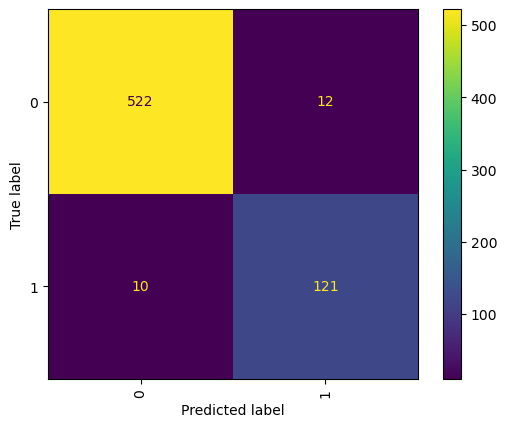

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(best_model_lr, X_valid, y_valid, xticks_rotation="vertical")

#### 6.1.2 Threshold Adjustment

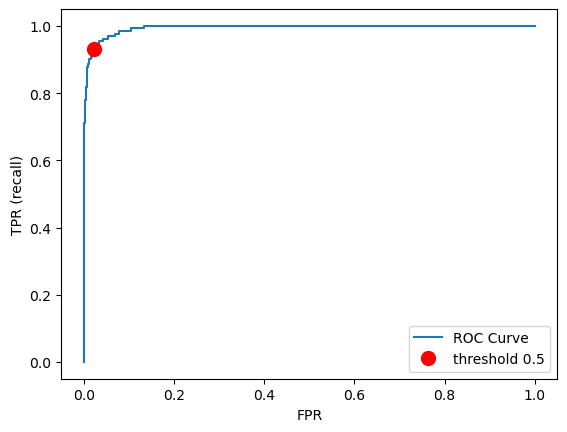

In [177]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_valid, best_model_lr.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [181]:
from sklearn.metrics import confusion_matrix

# Metrics for threshold = 0.5
proba = best_model_lr.predict_proba(X_valid)[:, 1]
predictions = np.array([1 if prob > 0.5 else 0 for prob in proba])
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall)
print(f"(threshold = 0.5) validation set's precision = {precision}, recall = {recall} & f1 = {f1_score}")
print(f"False negative = {FN}, False positive = {FP}")

# Metrics for threshold = 0.4
proba = best_model_lr.predict_proba(X_valid)[:, 1]
predictions = np.array([1 if prob > 0.4 else 0 for prob in proba])
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall)
print(f"(threshold = 0.4) validation set's precision = {precision}, recall = {recall} & f1 = {f1_score}")
print(f"False negative = {FN}, False positive = {FP}")


# Metrics for threshold = 0.3
proba = best_model_lr.predict_proba(X_valid)[:, 1]
predictions = np.array([1 if prob > 0.3 else 0 for prob in proba])
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = (2 * precision * recall) / (precision + recall)
print(f"(threshold = 0.3) validation set's precision = {precision}, recall = {recall} & f1 = {f1_score}")
print(f"False negative = {FN}, False positive = {FP}")


(threshold = 0.5) validation set's precision = 0.9097744360902256, recall = 0.9236641221374046 & f1 = 0.9166666666666667
False negative = 10, False positive = 12
(threshold = 0.4) validation set's precision = 0.8913043478260869, recall = 0.9389312977099237 & f1 = 0.9144981412639406
False negative = 8, False positive = 15
(threshold = 0.3) validation set's precision = 0.8503401360544217, recall = 0.9541984732824428 & f1 = 0.8992805755395683
False negative = 6, False positive = 22


### 6.2 Logistic Regression Coefficients

In [93]:
data = {
    "coefficient": best_model_lr.named_steps['logisticregression'].coef_.flatten().tolist(),
    "magnitude": np.absolute(
        best_model_lr.named_steps['logisticregression'].coef_.flatten().tolist()
    ),
}
coef_df = pd.DataFrame(data, index=col_names).sort_values(
    "magnitude", ascending=False
)

In [195]:
# Top 30 features contributing for positive class
coef_df.query('coefficient > 0').head(20)

coefficient  magnitude
archeology       1.603946   1.603946
266              0.935162   0.935162
paleontology     0.905358   0.905358
98               0.901789   0.901789
435              0.870517   0.870517
581              0.823432   0.823432
155              0.813350   0.813350
plant            0.804583   0.804583
357              0.796842   0.796842
355              0.777953   0.777953
645              0.774993   0.774993
17               0.760880   0.760880
88               0.754329   0.754329
732              0.751171   0.751171
767              0.746729   0.746729
28               0.736865   0.736865
earth            0.728381   0.728381
532              0.726672   0.726672
268              0.713226   0.713226
66               0.712840   0.712840

In [194]:
# Top 30 features contributing for negative class
coef_df.query('coefficient < 0').head(20)

coefficient  magnitude
multidisciplinary    -1.481149   1.481149
718                  -1.052560   1.052560
55                   -1.024120   1.024120
761                  -0.981127   0.981127
202                  -0.918883   0.918883
80                   -0.912003   0.912003
561                  -0.858692   0.858692
25                   -0.842352   0.842352
393                  -0.816468   0.816468
175                  -0.789976   0.789976
310                  -0.771930   0.771930
560                  -0.716381   0.716381
723                  -0.695125   0.695125
647                  -0.676681   0.676681
462                  -0.668046   0.668046
genetics             -0.666408   0.666408
37                   -0.665160   0.665160
engineering          -0.651139   0.651139
152                  -0.645217   0.645217
442                  -0.643118   0.643118

In [193]:
transformed_X_train_df_target = pd.merge(transformed_X_train_df, y_train, left_index=True, right_index=True)

In [197]:
subject_words = ['archeology', 'paleontology', 'plant', 'earth', 'genetics', 'engineering']

for word in subject_words:
    print("======= ", word, ' ========')
    print("counts in two groups")
    print(transformed_X_train_df_target.groupby('target')[word].sum())
    print("percentage in two groups")
    print(transformed_X_train_df_target.groupby('target')[word].sum()/transformed_X_train_df_target.groupby('target')[word].count())

=======  archeology  ========
counts in two groups
target
0    127.0
1     43.0
Name: archeology, dtype: float64
percentage in two groups
target
0    0.078589
1    0.078324
Name: archeology, dtype: float64
=======  paleontology  ========
counts in two groups
target
0    78.0
1    33.0
Name: paleontology, dtype: float64
percentage in two groups
target
0    0.048267
1    0.060109
Name: paleontology, dtype: float64
=======  plant  ========
counts in two groups
target
0    145.0
1     53.0
Name: plant, dtype: float64
percentage in two groups
target
0    0.089728
1    0.096539
Name: plant, dtype: float64
=======  earth  ========
counts in two groups
target
0    169.0
1     66.0
Name: earth, dtype: float64
percentage in two groups
target
0    0.104579
1    0.120219
Name: earth, dtype: float64
=======  genetics  ========
counts in two groups
target
0    115.0
1     44.0
Name: genetics, dtype: float64
percentage in two groups
target
0    0.071163
1    0.080146
Name: genetics, dtype: float64
==

### 6.3 Interpreting the sentence embeddings

#### 6.3.1 Correlation between sentence embeddings

In [116]:
# correlation between embeddings
column_names = [str(i) for i in range(1, 768)]

embeddings_feature = train_df[column_names]

correlation_matrix = embeddings_feature.corr()

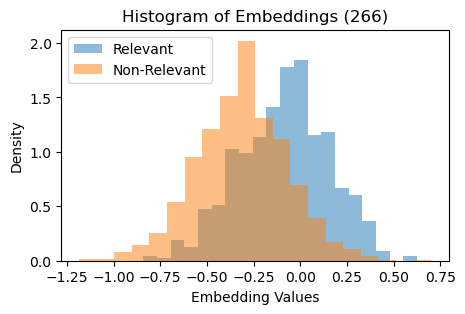

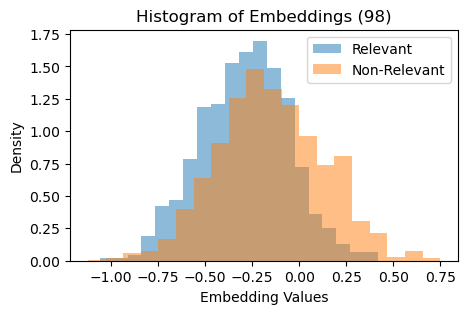

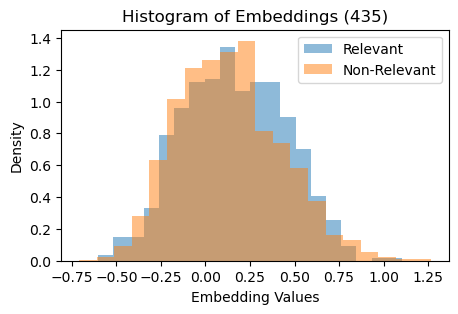

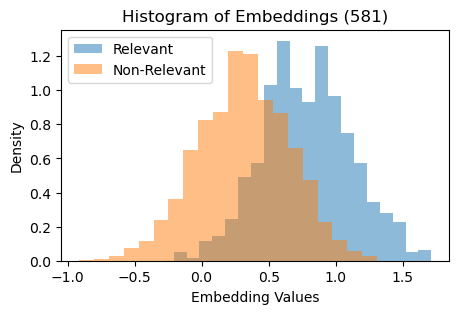

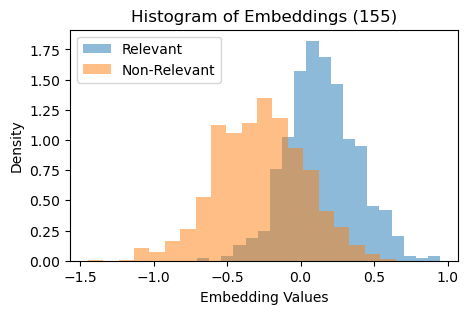

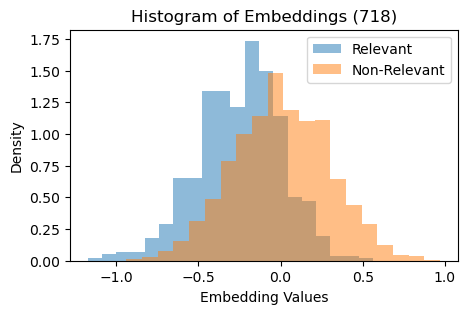

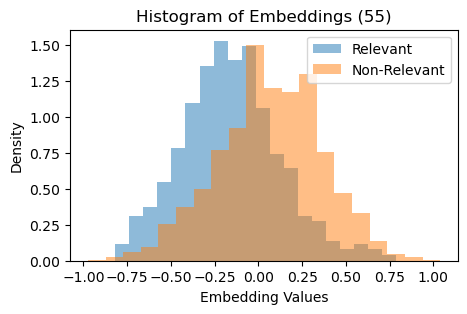

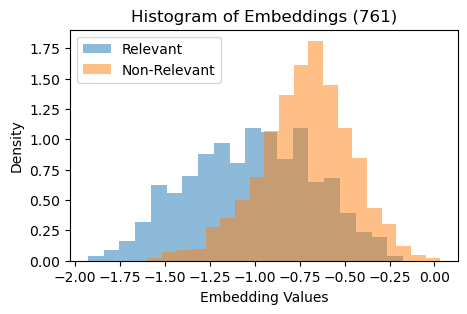

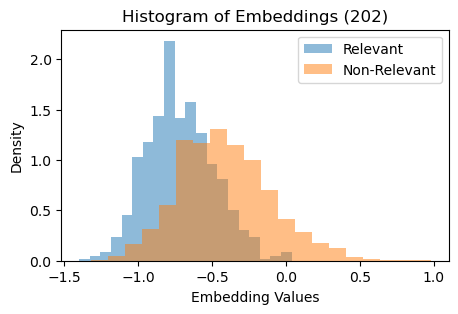

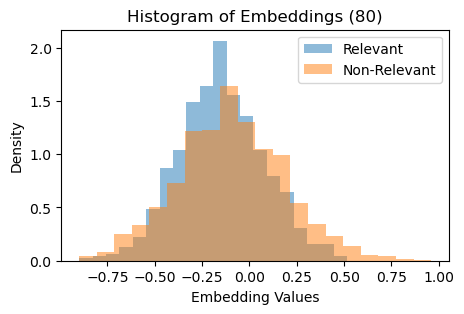

In [100]:
# Distribution of selected sentence embeddings
embeddings_to_show = ['266', '98', '435', '581', '155', '718', '55', '761', '202', '80']

# Separate data for each group
relevant_articles = train_df.query('target == 1')
nonrelevant_articles = train_df.query('target != 1')

for col in embeddings_to_show:
    plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
    plt.hist(relevant_articles[col], bins=20, alpha=0.5, label='Relevant', density=True)
    plt.hist(nonrelevant_articles[col], bins=20, alpha=0.5, label='Non-Relevant', density=True)
    plt.xlabel('Embedding Values')
    plt.ylabel('Density')
    plt.title(f'Histogram of Embeddings ({col})')
    plt.legend()
    plt.show()



#### 6.3.2 Word cloud for embeddings

In [151]:
def word_cloud(embedding, num_example = 10):
    text_large_coef = " ".join(train_df.sort_values(by = embedding, ascending = False).head(num_example)['text_with_abstract'].tolist())
    text_small_coef = " ".join(train_df.sort_values(by = embedding, ascending = False).tail(num_example)['text_with_abstract'].tolist())
    
    print('===============================')
    print(f" ======= Embedding: {embedding}, Coefficient: {coef_df.loc[embedding, 'coefficient']} ======= ")
    wordcloud = WordCloud(max_font_size=40, width=600, height=300)
    wordcloud.generate(text_large_coef).to_image()
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for {num_example} examples with highest value of embedding {embedding}.")
    plt.show()

    for text in train_df.sort_values(by = embedding, ascending = False).head(num_example)['text_with_abstract'].tolist():
        print("===")
        print(text)
    

    wordcloud = WordCloud(max_font_size=40, width=600, height=300)
    wordcloud.generate(text_small_coef).to_image()
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Wordcloud for {num_example} examples with lowest value of embedding {embedding}.")
    plt.show()
    
    for text in train_df.sort_values(by = embedding, ascending = False).tail(num_example)['text_with_abstract'].tolist():
        print("===")
        print(text)

 ======= Embedding: 266, Coefficient: 0.9351619218333026 ======= 


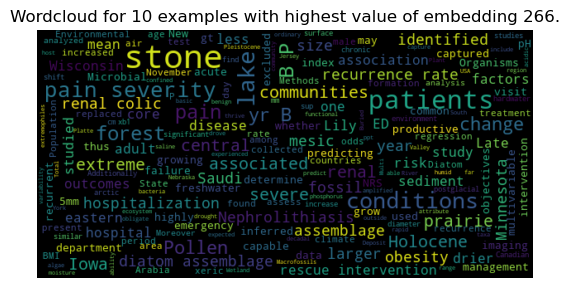

===
Communities that thrive in extreme conditions captured from a freshwater lake  Organisms that can grow in extreme conditions would be expected to be confined to extreme environments. However, we were able to capture highly productive communities of algae and bacteria capable of growing in acidic (pH 2), basic (pH 12) and saline (40 ppt) conditions from an ordinary freshwater lake. Microbial communities may thus include taxa that are highly productive in conditions that are far outside the range of conditions experienced in their host ecosystem. The organisms we captured were not obligate extremophiles, but were capable of growing in both extreme and benign conditions. The ability to grow in extreme conditions may thus be a common functional attribute in microbial communities.
===
Total phosphorus changes in New York and New Jersey lakes (USA) inferred from sediment cores  
===
Late Pleistocene Pollen and Plant Macrofossils from a Buried Wetland Deposit in the Platte River Valley, S

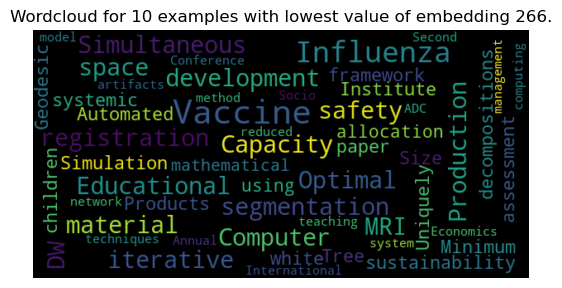

===
Minimum Size Tree-decompositions  
===
A systemic framework for sustainability assessment  
===
On the Optimal Production Capacity for Influenza Vaccine OPTIMAL PRODUCTION CAPACITY FOR INFLUENZA VACCINE 
===
The safety of influenza vaccines in children: An Institute for Vaccine Safety white paper  
===
What is Computer Simulation?  
===
On Products of Uniquely Geodesic Spaces  
===
Automated space allocation using mathematical techniques  
===
The Second Annual International Conference on Socio-Economics  
===
Educational material development model for teaching computer network and system management EDUCATIONAL MATERIAL DEVELOPMENT 
===
Simultaneous segmentation and iterative registration method for computing ADC with reduced artifacts from DW-MRI Simultaneous segmentation and iterative registration for DW-MRI 
 ======= Embedding: 98, Coefficient: 0.9017888351711706 ======= 


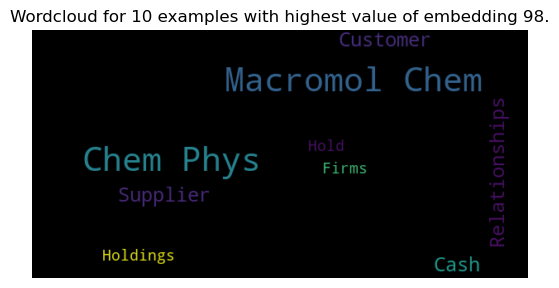

===
Why Do Firms in Customer-Supplier Relationships Hold More Cash? Customer-Supplier Relationships and Cash Holdings 
===
Macromol. Chem. Phys. 13/2015  
===
Macromol. Chem. Phys. 9/2015  
===
Macromol. Chem. Phys. 12/2015  
===
Macromol. Chem. Phys. 7/2015  
===
Macromol. Chem. Phys. 17/2015  
===
Macromol. Chem. Phys. 23/2015  
===
Macromol. Chem. Phys. 15/2015  
===
Macromol. Chem. Phys. 6/2015  
===
Macromol. Chem. Phys. 10/2015  


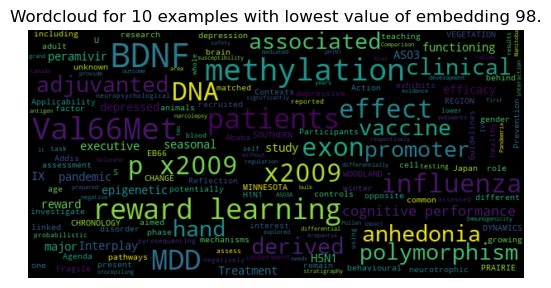

===
Clinical efficacy of peramivir in adult patients with seasonal influenza during the winter of 2012 in Japan Peramivir efficacy on seasonal influenza 
===
The Applicability of the Addis Ababa Action Agenda in Fragile Contexts—A Reflection  
===
CHRONOLOGY AND DYNAMICS OF VEGETATION CHANGE IN THE PRAIRIE-WOODLAND REGION OF SOUTHERN MINNESOTA, U.S.A. *  
===
A clinical phase I study of an EB66 cell-derived H5N1 pandemic vaccine adjuvanted with AS03  
===
Treatment and Prevention of Pandemic H1N1 Influenza  
===
Guidelines for the treatment of animals in behavioural research and teaching  
===
Interplay of Val66Met and BDNF methylation: effect on reward learning and cognitive performance in major depression  There is a growing interest in the role of brain-derived neurotrophic factor (BDNF) in major depressive disorder (MDD). BDNF potentially exhibits opposite effects in the pathways linked to anhedonia and reward learning on the one hand and cognitive performance, on the other hand. H

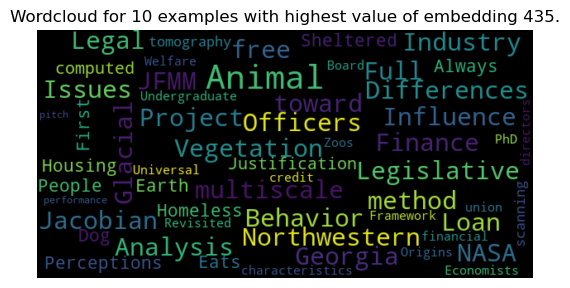

===
Influence of Industry on Legislative Behavior toward NASA  
===
Legal Issues in Project Finance  
===
Analysis of the Jacobian-free multiscale method (JFMM)  
===
The Full-Glacial Vegetation of Northwestern Georgia  
===
Differences in Loan Officers’ Perceptions of Earth-Sheltered Housing  
===
My Dog Always Eats First: Homeless People and Their Animals  
===
Justification for computed tomography scanning  
===
The Undergraduate Origins of PhD Economists Revisited  
===
A Universal Animal Welfare Framework for Zoos  
===
Board of directors characteristics and credit union financial performance: a pitch  


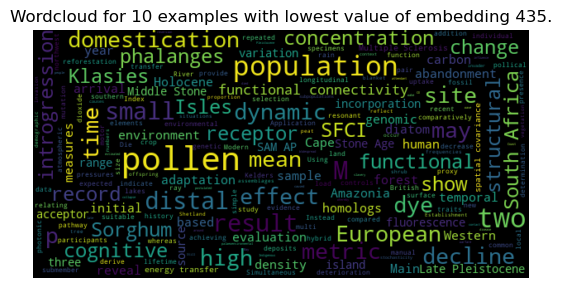

===
A late Pleistocene-Holocene multi-proxy record of palaeoenvironmental change from Still Bay, southern Cape Coast, South Africa PLEISTOCENE-HOLOCENE MULTI-PROXY RECORD, SOUTHERN CAPE 
===
Widespread reforestation before European influence on Amazonia  An estimated 90 to 95% of Indigenous people in Amazonia died after European contact. This population collapse is postulated to have caused decreases in atmospheric carbon dioxide concentrations at around 1610 CE, as a result of a wave of land abandonment in the wake of disease, slavery, and warfare, whereby the attendant reversion to forest substantially increased terrestrial carbon sequestration. On the basis of 39 Amazonian fossil pollen records, we show that there was no synchronous reforestation event associated with such an atmospheric carbon dioxide response after European arrival in Amazonia. Instead, we find that, at most sites, land abandonment and forest regrowth began about 300 to 600 years before European arrival. Pre-Europ

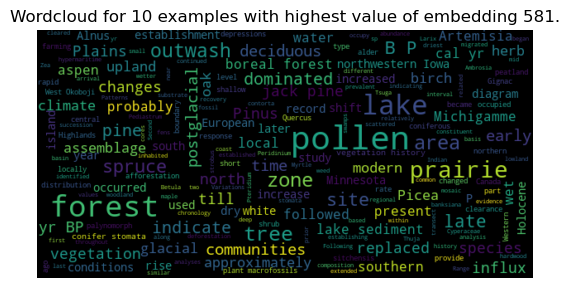

===
Myrtle Lake: a late- and post-glacial pollen diagram from northern Minnesota    A pollen diagram from a lake in the former bed of the eastern arm of Lake Agassiz in northern Minnesota records a vegetation of spruce forest followed by immigration successively of Pinus banksiana and (or) P. resinosa at 10 000 B.P., then Abies and Pteridium, and still later Alnus. Between 8000 and 7000 B.P. prairie and (or) Quercus savanna prevailed on the uplands, followed by deciduous forests of mainly Quercus, Ostrya virginiana, Fraxinus pennsylvanica, and possibly Populus sp.Slightly later, Pinus strobus migrated into the area, resulting in a gradual decline of pollen of deciduous forest types. Betula pollen, however, rises, and there is an indication of a return to prairie conditions prior to 3000 B.P.During the 8000–7000 B.P. dry interval the lowland vegetation consisted of fens of Typha latifolia, Dryopteris thelypteris, and Cyperaceae. Later paludification and lateral expansion of the peatland

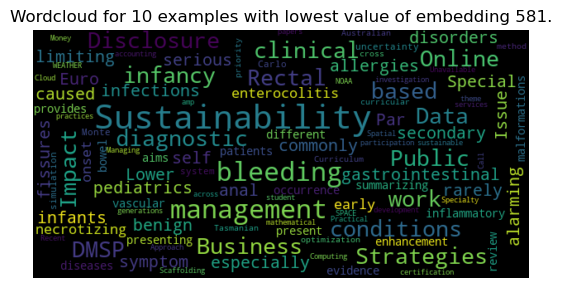

===
The Impact of Business Strategies on Online Sustainability Disclosures The Impact of Business Strategies and Online Sustainability Disclosure 
===
Special Issue: Euro-Par 2014  
===
Rectal bleeding in infants: diagnostic work-up and management  Lower gastrointestinal bleeding is an alarming symptom in pediatrics, especially in infancy. However, it is commonly secondary to benign and self-limiting conditions, such as anal fissures, infections, and allergies; more rarely it is caused by more serious disorders, such as necrotizing enterocolitis, very early onset inflammatory bowel diseases, and vascular malformations. The present review aims at summarizing the different clinical conditions presenting with rectal bleeding in infancy and provides an evidence-based diagnostic work-up for the clinical management of patients with this occurrence.
===
Sustainability enhancement under uncertainty: a Monte Carlo-based simulation and system optimization method  
===
Sustainability as a cross-c

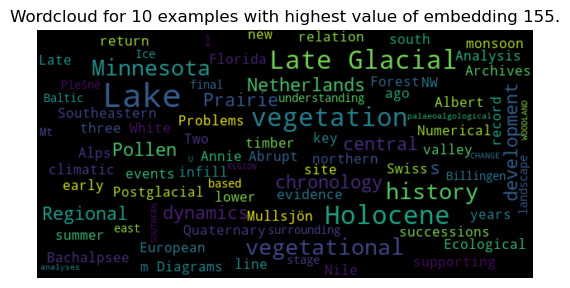

===
The Late-Glacial infill of three lake successions in The Netherlands: Regional vegetational history in relation to NW European vegetational developments  
===
Holocene timber-line dynamics at Bachalpsee, a lake at 2265 m a.s.l. in the northern Swiss Alps  
===
Abrupt return of the summer monsoon 15,000 years ago: new supporting evidence from the lower White Nile valley and Lake Albert  
===
A late Quaternary record of vegetation from Lake Annie, south-central Florida  
===
Late-glacial and early Holocene climatic events and chronology of vegetation development in the Netherlands  
===
Two Pollen Diagrams from Southeastern Minnesota: Problems in the Regional Late-Glacial and Postglacial Vegetational History  
===
A Numerical Analysis of Holocene Forest and Prairie Vegetation in Central Minnesota Ecological Archives 
===
Lake Mullsjön - a key site for understanding the final stage of the Baltic Ice Lake east of Mt. Billingen  
===
Late Glacial and Holocene history of Plešné Lake and 

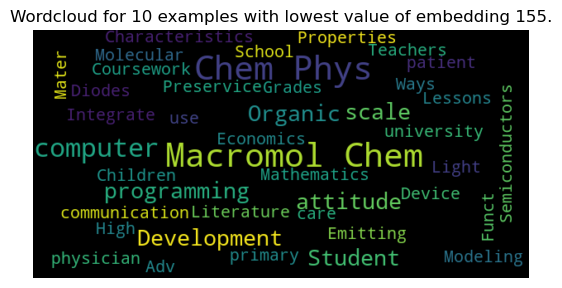

===
Development of computer programming attitude scale for university students DEVELOPMENT OF COMPUTER PROGRAMMING ATTITUDE SCALE 
===
Macromol. Chem. Phys. 11/2015  
===
Organic Semiconductors: Modeling of Organic Light Emitting Diodes: From Molecular to Device Properties (Adv. Funct. Mater. 13/2015)  
===
Macromol. Chem. Phys. 13/2015  
===
Macromol. Chem. Phys. 15/2015  
===
Macromol. Chem. Phys. 16/2015  
===
Ways that Preservice Teachers Integrate Children's Literature into Mathematics Lessons  
===
Macromol. Chem. Phys. 17/2015  
===
Computer use in primary care and patient-physician communication  
===
Grades, Coursework, and Student Characteristics in High School Economics  
 ======= Embedding: 718, Coefficient: -1.0525596853932684 ======= 


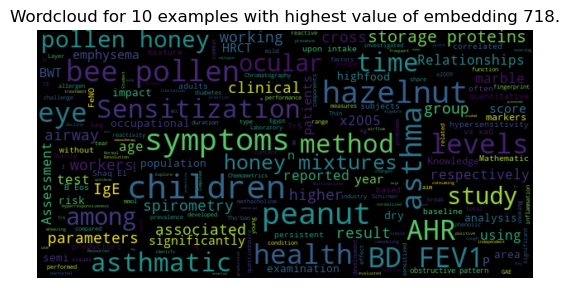

===
Erythema multiforme minor during sublingual immunotherapy  
===
Occupational ocular health problems among marble workers at Shaq El Tho’ban industrial area in Egypt  Eye health of the working population is an essential condition for productivity. Marble industry is processed at large scale at Shaq El Tho'ban area where much dust, crushed pieces of stone, and fluctuating temperatures are endangering employees' health generally and eye health specifically. The objectives of this study were assessing the prevalence of the most common ocular health problems associated with marble industry and investigating the impact of the working environment and occupational risk factors on the oculo-visual status of marble workers. A cross-sectional study was conducted among 250 workers, working at Shaq El Tho'ban area in Egypt during the period from August 2020 to September 2021, using a semi-structured questionnaire and eye examination comprised of full ocular history, visual acuity testing (unaid

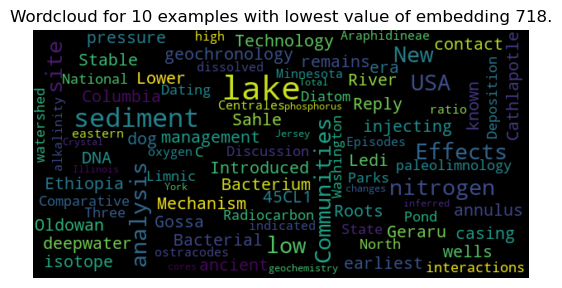

===
Mechanism of pressure management by injecting nitrogen in casing annulus of deepwater wells  
===
Effects of an Introduced Bacterium on Bacterial Communities on Roots  
===
Reply to Sahle and Gossa: Technology and geochronology at the earliest known Oldowan site at Ledi-Geraru, Ethiopia  
===
Stable isotope and ancient DNA analysis of dog remains from Cathlapotle (45CL1), a contact-era site on the Lower Columbia River  
===
The paleolimnology of North Pond: watershed-lake interactions  
===
Radiocarbon Dating of Limnic Sediments: A Comparative Analysis and Discussion  
===
Nitrogen Deposition Effects on Diatom Communities in Lakes from Three National Parks in Washington State  
===
The A/C (Araphidineae/Centrales) ratio in high and low alkalinity lakes in eastern Minnesota  
===
Episodes of low dissolved oxygen indicated by ostracodes and sediment geochemistry at Crystal Lake, Illinois, USA  
===
Total phosphorus changes in New York and New Jersey lakes (USA) inferred from sediment

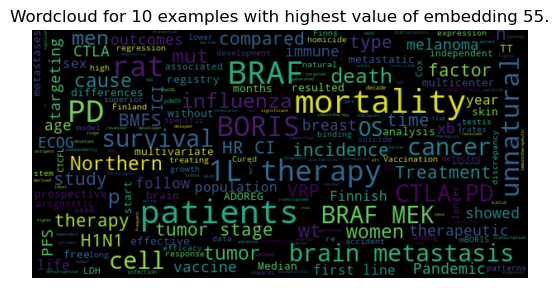

===
Brain metastasis and survival outcomes after first-line therapy in metastatic melanoma: a multicenter DeCOG study on 1704 patients from the prospective skin cancer registry ADOREG  Despite the availability of effective systemic therapies, a significant number of advanced melanoma patients develops brain metastases. This study investigated differences in incidence and time to diagnosis of brain metastasis and survival outcomes dependent on the type of first-line therapy. Patients with metastatic, non-resectable melanoma (AJCCv8 stage IIIC-V) without brain metastasis at start of first-line therapy (1L-therapy) were identified from the prospective multicenter real-world skin cancer registry ADOREG. Study endpoints were incidence of brain metastasis, brain metastasis-free survival (BMFS), progression-free survival (PFS), and overall survival (OS). Of 1704 patients, 916 were BRAF wild-type (BRAF<i>wt</i>) and 788 were BRAF V600 mutant (BRAF<i>mut</i>). Median follow-up time after start 

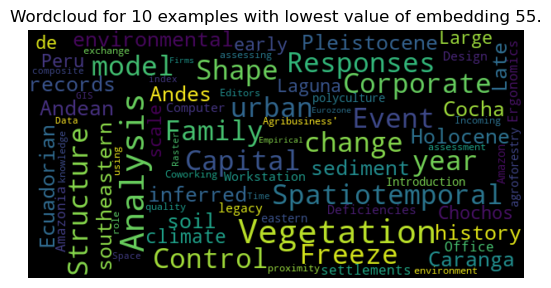

===
Late Pleistocene and Holocene environmental change inferred from the Cocha Caranga sediment and soil records in the southeastern Ecuadorian Andes  
===
A 17 000-year history of Andean climate and vegetation change from Laguna de Chochos, Peru  
===
Large-scale early urban settlements in Amazonia  
===
Office Ergonomics: Deficiencies in Computer Workstation Design  
===
The legacy of 4,500 years of polyculture agroforestry in the eastern Amazon  
===
An Introduction to Agribusiness' Incoming Editors  
===
Coworking: assessing the role of proximity in knowledge exchange  
===
Urban environment quality assessment by using composite index model  
===
A Space-Time Raster GIS Data Model for Spatiotemporal Analysis of Vegetation Responses to a Freeze Event Spatiotemporal Analysis of Vegetation Responses to a Freeze Event 
===
Does Family Control Shape Corporate Capital Structure? An Empirical Analysis of Eurozone Firms DOES FAMILY CONTROL SHAPE CORPORATE CAPITAL STRUCTURE? 
 ======= Embed

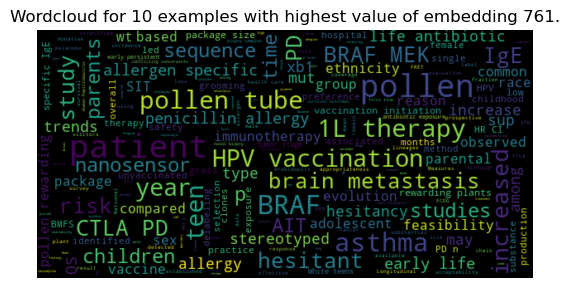

===
Feasibility of a Centralized, Pharmacy-Led Penicillin Allergy Delabeling Program  Penicillin allergy labels are often inaccurate in children and removing unnecessary labels results in improved outcomes and lower health care costs. Although the hospital setting is a frequent point of contact for children, strategies to evaluate penicillin allergies in the hospital are lacking. We performed a prospective pilot study to determine the feasibility of a centralized, pharmacy-led approach to penicillin allergy evaluation. Children with a reported history of penicillin allergy admitted to our children's hospital were risk-stratified and those stratified as low-risk underwent a single-dose oral challenge by a central pharmacist, regardless of the need for antibiotics. After the completion of each patient's delabeling process, surveys were distributed to health care personnel involved in the patient's care to collect perceptions on the acceptability, appropriateness, and feasibility of this 

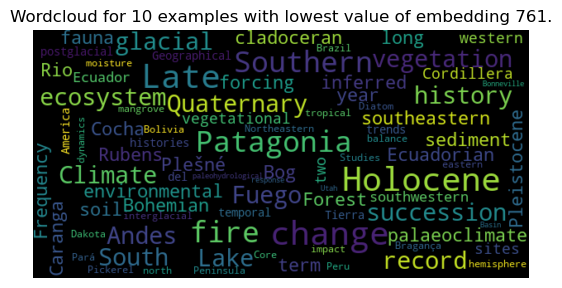

===
Holocene Fire Frequency and Climate Change at Rio Rubens Bog, Southern Patagonia  
===
Late Pleistocene and Holocene environmental change inferred from the Cocha Caranga sediment and soil records in the southeastern Ecuadorian Andes  
===
The long-term succession of cladoceran fauna and palaeoclimate forcing: A 14,600-year record from Plešné Lake, the Bohemian Forest  
===
Late-glacial and Holocene vegetational history from two sites in the western Cordillera of southwestern Ecuador  
===
Geographical and temporal trends in Late Quaternary fire histories of Fuego-Patagonia, South America  
===
Late and postglacial vegetation and fire history in Southern Patagonia and Tierra del Fuego  
===
Glacial-interglacial changes in moisture balance and the impact on vegetation in the southern hemisphere tropical Andes (Bolivia/Peru)  
===
Diatom Succession in a Core from Pickerel Lake, Northeastern South Dakota  
===
Studies on Holocene mangrove ecosystem dynamics of the Bragança Peninsula in

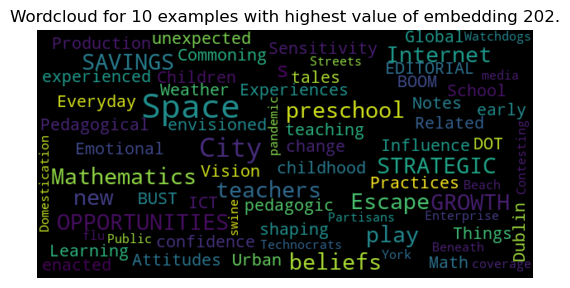

===
ICT and play in preschool: early childhood teachers’ beliefs and confidence  
===
The Internet of Things: shaping the new Internet space EDITORIAL 
===
Mathematics teaching: tales of the unexpected  
===
Preschool Teachers’ Sensitivity to Mathematics in Children’s Play: The Influence of Math-Related School Experiences, Emotional Attitudes, and Pedagogical Beliefs  
===
Learning spaces and pedagogic change: envisioned, enacted and experienced  
===
GROWTH OPPORTUNITIES, STRATEGIC SAVINGS, AND THE DOT-COM BOOM AND BUST GROWTH OPPORTUNITIES AND STRATEGIC SAVINGS 
===
Escape into the City: Everyday Practices of Commoning and the Production of Urban Space in Dublin Escape into the City 
===
Notes on a Vision for the Global Space Weather Enterprise  
===
The Beach Beneath the Streets: Contesting New York City 's Public Spaces  
===
The Partisans, the Technocrats and the Watchdogs Domestication in media coverage of the swine flu pandemic in 2009 


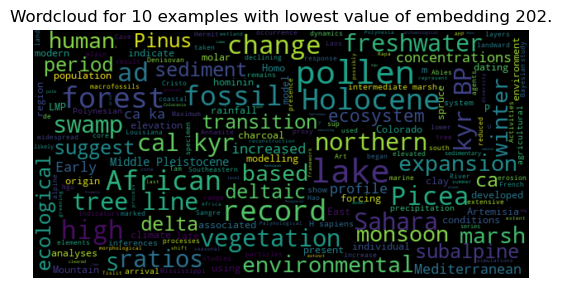

===
Holocene timber-line dynamics at Bachalpsee, a lake at 2265 m a.s.l. in the northern Swiss Alps  
===
Postglacial environmental change of a high-elevation forest, Sangre de Cristo Mountains of south-central Colorado   ABSTRACT 
                Continuous sediment, pollen, and charcoal records were developed from an 8.46-m-long sediment core taken from Hermit Lake in the northern Sangre de Cristo mountain range of Colorado. Presently, vegetation around the lake is upper subalpine forest, consisting of Picea engelmannii (Englemann spruce) with some Abies lasiocarpa (subalpine fir), and the lake lies &amp;gt;200 m below present tree line. We used several pollen ratios to reconstruct the relative position of the tree line and the occurrence of clay layers to infer landscape instability through time. 
                Deglaciation of the Hermit Lake drainage began during the Bølling-Allerød interval. Between ca. 13.5 and 12.4 ka, high Artemisia (sagebrush) pollen abundance, low Picea/Pin

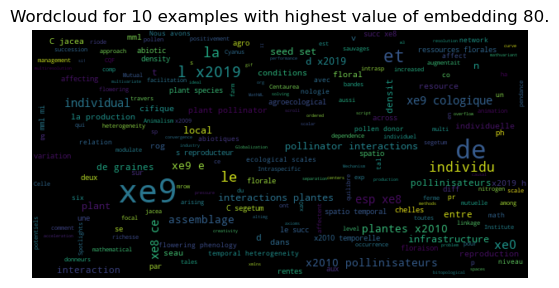

===
<mml:math xmlns:mml="http://www.w3.org/1998/Math/MathML" altimg="si1.gif" overflow="scroll"><mml:mrow><mml:mi mathvariant="script">I</mml:mi><mml:mi>P</mml:mi></mml:mrow></mml:math>-separation axioms in ideal bitopological ordered spaces II  
===
Globalization of the animation industry: multi-scalar linkages of six animation production centers  
===
Is there a causal relation between mathematical creativity and mathematical problem-solving performance?  
===
A multiresolution approach for the convergence acceleration of multivariate curve resolution methods  
===
Mechanism of pressure management by injecting nitrogen in casing annulus of deepwater wells  
===
Animalism Animalism 
===
Rockonomix  
===
CQF Institute Spotlights CQF Institute Spotlights 
===
The Investment Theories of Kalecki and Keynes: An Empirical Study of Firm Data, 1970–1982  
===
Individual flowering phenology shapes plant–pollinator interactions across ecological scales affecting plant reproduction  The balance 

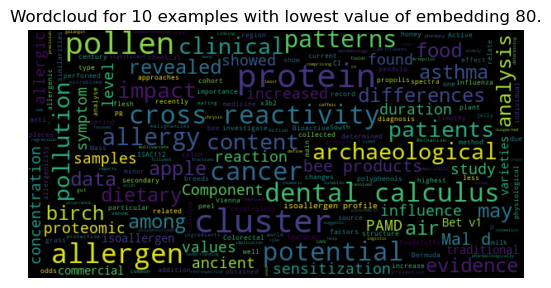

===
Bee Products and Colorectal Cancer—Active Components and Mechanism of Action  Colorectal cancer is one of the most common malignancies in the world. Lifestyle and eating patterns may have a significant impact on the prevention of this type of cancer. Bioactive food ingredients influence the gut microbiome and can have a protective effect. Bee products (honey, propolis, royal jelly, and bee venom) or pharmacologically active fractions obtained from them are widely used in many fields of medicine, pharmacy, and cosmetics. Some evidence suggests that bee products may have anti-cancer potential. The main bioactive components with anti-colon cancer potential from propolis and bee honey are polyphenols such as pinocembrin, galangin, luteolin, CAPE, Artepilin C, chrysin, caffeic, and p-coumaric acids. This review is focused on the new data on epidemiology, risk factors for colon cancer, and current reports on the potential role of bee products in the chemoprevention of this type of cancer

In [152]:
embeddings_to_show = ['266', '98', '435', '581', '155', '718', '55', '761', '202', '80']
for col in embeddings_to_show:
    word_cloud(col, num_example = 10)

#### 6.3.4 StatModel for logisitc regression

In [173]:
import statsmodels.api as sm

X = transformed_X_train_df
y = np.asarray(y_train)

X = sm.add_constant(X)

# X = X + 0.00001*np.random.rand(X.shape[0], 1) # add random noise to prevent LinAlgError: Singular matrix

In [174]:
logit_model = sm.Logit(y, X)

result = logit_model.fit(method='bfgs')

print(result.summary())

         Current function value: 0.042900
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/kw/opt/miniconda3/envs/591/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3103
Model:                          Logit   Df Residuals:                     2095
Method:                           MLE   Df Model:                         1007
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                  0.9155
Time:                        01:23:39   Log-Likelihood:                -133.12
converged:                      False   LL-Null:                       -1575.2
Covariance Type:            nonrobust   LLR p-value:                2.807e-180
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1071        nan        nan        nan         nan         nan
is-referenced-by-count     0.1786        nan        nan        nan         nan         nan
has_

### 6.4 Case-by-case investigation

In [76]:
predictions = best_model_lr.predict(X_test)
probs = best_model_lr.predict_proba(X_test)
test_df['predictions'] = predictions
test_df['pred_proba_1'] = probs[:, 1]

In [81]:
# False Positives
test_df.query('target == 0 & predictions == 1')

is-referenced-by-count  has_abstract  \
4392                       8             1   
2686                      12             1   
3952                       2             0   
2182                       6             1   
3168                      36             0   
3076                      22             0   
3566                      10             0   
2627                       1             0   
2942                      28             0   
3300                       9             1   

                                          subject_clean  \
4392                  Immunology Immunology and Allergy   
2686                                  Multidisciplinary   
3952  Plant Science Ecology Ecology, Evolution, Beha...   
2182               General Earth and Planetary Sciences   
3168  Anthropology Ecology, Evolution, Behavior and ...   
3076  Anthropology Ecology, Evolution, Behavior and ...   
3566  Library and Information Sciences Statistics, P...   
2627                                  Multidisciplinary   
2942                                  Multidisciplinary   
3300                                  Multidisciplinary   

                                     text_with_abstract  target         0  \
4392   Climate change, airborne pollen, and pollution         0  0.286190   
2686  Evidence grows that peopling of the Americas b...       0  0.040969   
3952  Taxon Cycles in Neotropical Mangroves  The con...       0  0.588416   
2182  A Space-Time Raster GIS Data Model for Spatiot...       0  0.375969   
3168  Stable isotope paleoecology of Late Pleistocen...       0  0.687200   
3076  Hominin diversity and high environmental varia...       0  0.376971   
3566  A statistics-based reconstruction of high-reso...       0 -0.151691   
2627  Settlement, environment, and climate change in...       0 -0.011859   
2942  Using artificial neural networks to predict fu...       0  0.877768   
3300  Tropical forests as key sites of the “Anthropo...       0  0.775731   

             1         2         3         4  ...       760       761  \
4392 -0.185846  0.816835  0.203684  0.401631  ...  0.410998 -0.889461   
2686  0.548009  0.120604  0.094556  0.681848  ... -0.008162 -0.781698   
3952 -0.053824 -0.050785  0.251222  0.885861  ...  0.301806 -0.701965   
2182 -0.532317  0.283390  0.009962  0.677625  ...  0.644118 -1.023055   
3168  0.038780 -0.276628 -0.181212  0.665542  ...  0.420955 -0.682726   
3076  0.298666 -0.116250  0.217207  0.566766  ...  0.441397 -0.627667   
3566  0.001149  0.126745  0.233115  0.353917  ...  0.601525 -1.029252   
2627  0.451700  0.266275  0.226864  0.731320  ...  0.319172 -0.649614   
2942 -0.183808  0.479890  0.391845  0.721149  ... -0.119612 -0.677910   
3300  0.342960 -0.285565  0.015088  0.498305  ... -0.017006 -1.405690   

           762       763       764       765       766       767  predictions  \
4392 -0.364534 -0.207057 -0.299254 -0.281543 -0.260581 -0.794059            1   
2686 -0.021897 -0.204032 -0.477088  0.273001 -0.644550 -0.298202            1   
3952 -0.017652 -0.556827 -0.672958  0.030318 -0.180302 -0.722493            1   
2182 -0.541022 -0.282278 -0.336280 -0.168137  0.022882 -0.405805            1   
3168 -0.282745 -0.406084 -0.203722  0.075537  0.023365 -0.889069            1   
3076 -0.192676 -0.510259 -0.341850  0.050095 -0.157582 -0.771408            1   
3566 -0.046918 -0.530886 -0.370243  0.185384 -0.026844 -0.558948            1   
2627 -0.310891 -0.415376 -0.580483 -0.232780 -0.078169 -0.711891            1   
2942 -0.173062 -0.555423 -0.100679 -0.292753 -0.223760 -0.798118            1   
3300 -0.211421 -1.061171 -0.508970  0.321076 -0.458389 -0.622318            1   

      pred_proba_1  
4392      0.784324  
2686      0.501312  
3952      0.820017  
2182      0.545247  
3168      0.872077  
3076      0.595572  
3566      0.779811  
2627      0.565869  
2942      0.833220  
3300      0.935645  

[10 rows x 775 columns]

In [83]:
# False Negative
test_df.query('target == 1 & predictions == 0')

is-referenced-by-count  has_abstract  \
148                       35             1   
3672                       5             0   
601                        2             0   
3399                       0             0   
3479                       0             0   
3154                       2             0   
3445                      33             0   
632                       32             1   
2740                       0             0   
2953                      27             0   
3882                       2             0   
4054                       2             0   
3048                       1             0   
3835                       3             0   
3263                       0             1   
3650                      19             0   
3434                      17             0   
4178                       0             0   
4197                       0             0   
2613                      13             0   

                                          subject_clean  \
148   Paleontology Ecology, Evolution, Behavior and ...   
3672  Anthropology Ecology, Evolution, Behavior and ...   
601   Museology Archeology Arts and Humanities (misc...   
3399                                      Plant Science   
3479                                      Plant Science   
3154  Pollution Waste Management and Disposal Enviro...   
3445  Anthropology Ecology, Evolution, Behavior and ...   
632   Pollution Water Science and Technology Ecologi...   
2740                                      Plant Science   
2953  Anthropology Ecology, Evolution, Behavior and ...   
3882  General Agricultural and Biological Sciences A...   
4054                                  Multidisciplinary   
3048  History and Philosophy of Science General Agri...   
3835  General Agricultural and Biological Sciences G...   
3263  Ecology Ecology, Evolution, Behavior and Syste...   
3650  General Environmental Science Ecology Environm...   
3434  Library and Information Sciences Statistics, P...   
4178  General Agricultural and Biological Sciences G...   
4197                                      Plant Science   
2613                                  Multidisciplinary   

                                     text_with_abstract  target         0  \
148   A general framework for determining cutoff val...       1  0.403553   
3672  Site occupation dynamics of early modern human...       1  0.449283   
601   Bison Jump Location is Primarily Predicted by ...       1  0.023915   
3399  Fossil pollen resolves origin of the South Afr...       1  0.799006   
3479  Reclamation in southern China: The early Chu’s...       1  0.014343   
3154  Alkalinity and diatom assemblages in lowland s...       1  0.294494   
3445  Site fragmentation, hominin mobility and LCT v...       1  0.581317   
632   Algal microfossils provide high temporal resol...       1 -0.098108   
2740  Plant foods consumed at the Neolithic site of ...       1  0.148074   
2953  Climatic controls on Later Stone Age human ada...       1  0.660950   
3882  The earliest pollen-loaded insects from the Lo...       1  0.405678   
4054  Epipalaeolithic animal tending to Neolithic he...       1  0.464438   
3048  Blowing in the Wind: Pollen’s Mobility as a Ch...       1 -0.081478   
3835  A New Clue for the Late Eocene Freshwater Ecos...       1  0.289730   
3263  Reduction in grain pollen indicates population...       1  0.604890   
3650  Effects of future climate change on birch abun...       1  0.151413   
3434  FosSahul 2.0, an updated database for the Late...       1 -0.112520   
4178  Large mammals and trees in eastern monsoonal C...       1  0.404028   
4197  The history of olive cultivation in the southe...       1  0.546940   
2613  Reimagining the relationship between Gondwanan...       1  0.727186   

             1         2         3         4  ...       760       761  \
148  -0.165895 -0.270389 -0.181532  0.586620  ...  0.067820 -1.073519   
3672  0.267687 -0.048953 -0.130643 